In [1]:
import os
import numpy as np
import torchvision.models.segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as tf
from torch.utils.data import Dataset
import cv2
from torch.utils import data
import matplotlib.pyplot as plt
from tqdm import tqdm

import segmentation_models_pytorch
import csv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


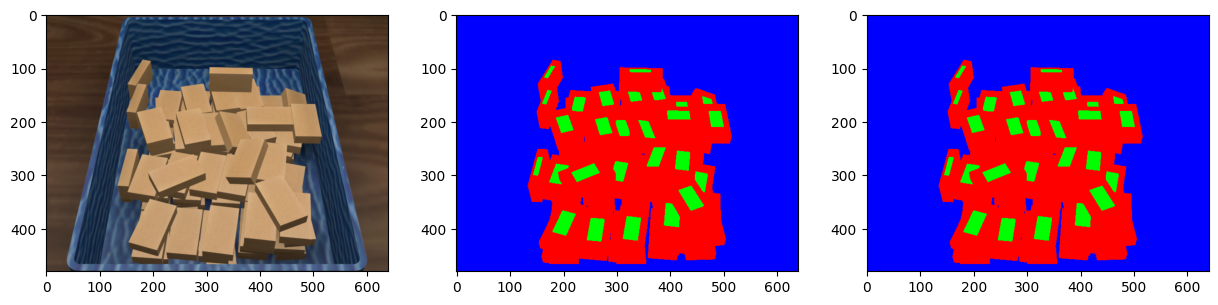

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


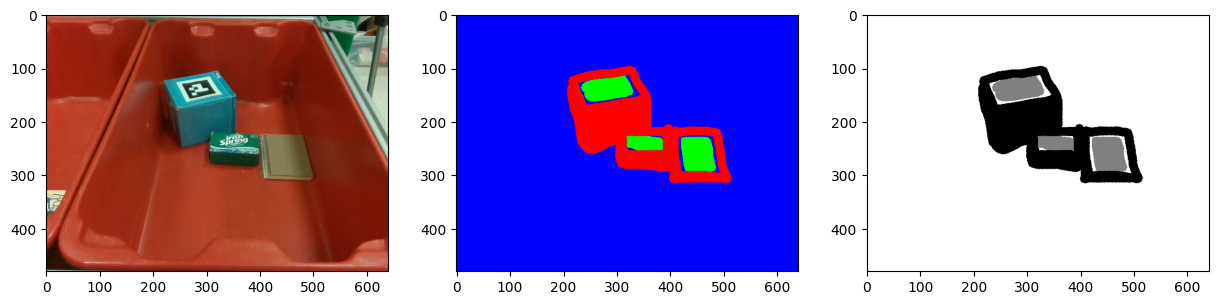

In [21]:
# Create custom dataset class
class SegNetDataset(Dataset):
    def __init__(self, data_dir, data_syn_dir, transform=None):
        self.data_dir = data_dir
        self.data_syn_dir = data_syn_dir

        self.transform = transform
        self.images_real = os.listdir(os.path.join(data_dir, 'color-input'))
        self.images_synthetic = os.listdir(os.path.join(data_syn_dir, 'color-input'))

        self.masks_real  = os.listdir(os.path.join(data_dir, 'label'))
        self.masks_synthetic  = os.listdir(os.path.join(data_syn_dir, 'label'))

        # Concatenate real and synthetic data
        self.images = self.images_real + self.images_synthetic
        self.masks = self.masks_real + self.masks_synthetic

        
    def __len__(self):
        return len(self.images)

    def create_mask(self, mask):
        # Create empty target mask
        target_mask = np.array(mask, dtype=np.uint8)

        # Create mask for each class
        target_mask[np.where((mask == [0, 0, 0]).all(axis=2))]       = [255, 0, 0]
        target_mask[np.where((mask == [128, 128, 128]).all(axis=2))] = [0, 255, 0]
        target_mask[np.where((mask == [255, 255, 255]).all(axis=2))] = [0, 0, 255]

        return target_mask

    def __getitem__(self, idx):
        synthetic = False
        if self.images[idx] in self.images_real:
            img_path    = os.path.join(self.data_dir, 'color-input', self.images[idx])
            mask_path   = os.path.join(self.data_dir, 'label', self.masks[idx])
        else:
            img_path    = os.path.join(self.data_syn_dir, 'color-input', self.images[idx])
            mask_path   = os.path.join(self.data_syn_dir, 'label', self.masks[idx])
            synthetic = True

        # Read image and mask
        image = cv2.imread(img_path)
        mask  = cv2.imread(mask_path)

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.cvtColor(mask,  cv2.COLOR_BGR2RGB)
        if synthetic:
            target_mask = mask
        else:
            target_mask = self.create_mask(mask)


        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            target_mask = self.transform(target_mask)

        # Permute the image dimensions to (H, W, C)
        image = image.permute(1, 2, 0)
        mask = mask.permute(1, 2, 0)
        target_mask = target_mask.permute(1, 2, 0)

        return image, target_mask, mask    #, depth


transforms = tf.Compose([
    tf.ToTensor(), # This converts from 0,255 to 0,1
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_dir = 'data'
data_syn_dir = 'data_synthetic'
dataset = SegNetDataset(data_dir='data', data_syn_dir=data_syn_dir, transform=transforms)

# Split dataset into train and test
train_data, test_data = data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# Create dataloaders
train_loader = data.DataLoader(train_data, batch_size=2, shuffle=True)
test_loader  = data.DataLoader(test_data, batch_size=2, shuffle=False)

# Load a test batch
images, target_mask, masks = next(iter(train_loader))

# Create a function that transform the one-hot encoded mask to an RGB image by scaling the values to 0-255
def mask_to_image(mask):
    mask = mask * 255
    # mask = mask.permute(1, 2, 0)
    # print(mask.shape)
    # print(mask)
    return mask

def create_plot(images, target_masks, masks, n_plots=2, figsize=(15,15)):
    for i in range(n_plots):
      fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
      ax[0].imshow(images[i])
      ax[1].imshow(target_mask[i]*255)
      ax[2].imshow(masks[i], cmap='gray')
      plt.show()

create_plot(images, target_mask, masks, n_plots=2, figsize=(15,15))


In [12]:
# Find GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get ResNet101 pretrained model to use as encoder
model = segmentation_models_pytorch.Unet(encoder_name='resnet101', 
                                         encoder_weights='imagenet', 
                                         classes=3, 
                                         activation=None,
                                         encoder_depth=5, 
                                         decoder_channels = (256, 128, 64, 32, 16),
                                        #  encoder_depth=2, 
                                        #  decoder_channels = (32, 16)
                                         )

# print(model)
model.encoder.train = False
model.decoder.train = True
model.segmentation_head.train = True

# Print model children
# for name, child in model.named_children():
#     print(name)

# Move model to GPU
model.to(device) #1GB GPU


criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

# Create train and evaluate functions

In [20]:
# Define function to calculate accuracy
def accuracy(outputs, targets):
    # Permute to (B, H, W, C)
    outputs = outputs.permute(0, 2, 3, 1)
    targets = targets.permute(0, 2, 3, 1)

    # Find max value and index of max value
    max_values, _ = torch.max(outputs, dim=3) # Here dim=3 because we want to find max value for class
    outputs_targets = (outputs == max_values.unsqueeze(3)).float().round()

    # Find true positives, false positives, false negatives
    true_positives  = torch.where((outputs_targets == targets) & (targets == 1), 1, 0).sum(dim=(0, 1, 2))
    false_positives = torch.where((outputs_targets != targets) & (targets == 0), 1, 0).sum(dim=(0, 1, 2))
    false_negatives = torch.where((outputs_targets != targets) & (targets == 1), 1, 0).sum(dim=(0, 1, 2))

    # How to deal with 0 values
    true_positives  = torch.where(true_positives  == 0, 1, true_positives)
    false_positives = torch.where(false_positives == 0, 1, false_positives)
    false_negatives = torch.where(false_negatives == 0, 1, false_negatives)

    # Print true positives, false positives, false negatives
    # print(f'True positives: {true_positives}')
    # print(f'False positives: {false_positives}')
    # print(f'False negatives: {false_negatives}')

    # Calculate recall and precision
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)


    # Print recall and precision
    # print(f'Recall: {recall.mean()}')
    # print(f'Precision: {precision.mean()}')

    return recall.mean(), precision.mean()



# Define train function that returns loss for each epoch and the accuracy
def train(model, train_loader, criterion, optimizer, device):
    # model.train()
    train_loss = 0.0
    train_recall_running, train_precision_running = 0.0, 0.0

    for images, target_mask, masks in tqdm(train_loader):
        images = images.to(device)
        target_mask = target_mask.to(device)

        images = images.permute(0, 3, 1, 2)
        target_mask = target_mask.permute(0, 3, 1, 2)

        # print(images.shape)
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate accuracy
        train_recall, train_precision = accuracy(outputs, target_mask)
        train_recall_running += train_recall
        train_precision_running += train_precision

        # Calculate loss
        loss = criterion(outputs, target_mask.argmax(dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # outputs = outputs.permute(0, 2, 3, 1)
    # target_mask = target_mask.permute(0, 2, 3, 1)
    return train_loss/len(train_loader), train_recall_running/len(train_loader), train_precision_running/len(train_loader), images.cpu().detach().numpy(), outputs.cpu().detach().numpy(), target_mask.cpu().detach().numpy()


# Define test function
def test(model, test_loader, criterion, device):
    # model.eval()
    test_loss = 0.0
    test_recall_running, test_precision_running = 0.0, 0.0

    with torch.no_grad():
        for images, target_mask, masks in tqdm(test_loader):
            images = images.to(device)
            target_mask = target_mask.to(device)
            
            images = images.permute(0, 3, 1, 2)
            target_mask = target_mask.permute(0, 3, 1, 2)

            outputs = model(images)
           
            # Calculate loss
            loss = criterion(outputs, target_mask.argmax(dim=1))
            test_loss += loss.item()

            # Calculate accuracy
            test_recall, test_precision = accuracy(outputs, target_mask)
            test_recall_running += test_recall
            test_precision_running += test_precision

    return test_loss/len(test_loader), test_recall_running/len(test_loader), test_precision_running/len(test_loader), images.cpu().detach().numpy(), outputs.cpu().detach().numpy(), target_mask.cpu().detach().numpy()

# Train and evaluate

  0%|          | 0/735 [00:00<?, ?it/s]

torch.Size([3, 480, 640])
tensor([[[2.1272e-01, 2.4748e-01, 1.4490e-01,  ..., 1.3041e-02,
          3.7785e-02, 5.9468e-02],
         [2.1339e-01, 2.1312e-01, 1.4242e-01,  ..., 5.7905e-03,
          3.6071e-02, 3.2822e-02],
         [1.4868e-01, 1.8572e-01, 7.5081e-02,  ..., 1.7693e-03,
          7.6881e-03, 1.5823e-02],
         ...,
         [1.7798e-02, 1.6303e-02, 2.3104e-03,  ..., 8.1545e-03,
          4.6087e-02, 4.2543e-02],
         [6.9026e-02, 9.7954e-02, 1.8973e-02,  ..., 6.8160e-02,
          1.2074e-01, 1.5910e-01],
         [6.8948e-02, 6.4834e-02, 1.9396e-02,  ..., 4.0253e-02,
          1.1930e-01, 1.1252e-01]],

        [[8.6234e-02, 7.6280e-02, 4.0217e-02,  ..., 1.4099e-04,
          3.7330e-03, 2.9522e-03],
         [8.6760e-02, 8.1906e-02, 4.0308e-02,  ..., 1.4042e-04,
          3.6530e-03, 2.7254e-03],
         [4.2504e-02, 3.6498e-02, 1.2283e-02,  ..., 2.2689e-06,
          2.5717e-04, 1.9405e-04],
         ...,
         [1.0678e-03, 7.9868e-04, 3.3982e-05,  ..., 2

  0%|          | 1/735 [00:00<08:01,  1.52it/s]

torch.Size([3, 480, 640])


  0%|          | 2/735 [00:01<06:51,  1.78it/s]

tensor([[[2.1297e-01, 2.4774e-01, 1.4464e-01,  ..., 1.5156e-02,
          4.2170e-02, 6.5245e-02],
         [2.1362e-01, 2.1341e-01, 1.4216e-01,  ..., 6.9290e-03,
          4.0311e-02, 3.6866e-02],
         [1.4919e-01, 1.8628e-01, 7.5231e-02,  ..., 2.1792e-03,
          9.0068e-03, 1.8098e-02],
         ...,
         [1.8175e-02, 1.6675e-02, 2.3990e-03,  ..., 8.6893e-03,
          4.7806e-02, 4.4215e-02],
         [6.9773e-02, 9.8867e-02, 1.9381e-02,  ..., 7.0563e-02,
          1.2371e-01, 1.6230e-01],
         [6.9686e-02, 6.5593e-02, 1.9807e-02,  ..., 4.2028e-02,
          1.2224e-01, 1.1550e-01]],

        [[8.6343e-02, 7.6360e-02, 4.0021e-02,  ..., 1.8999e-04,
          4.4956e-03, 3.5742e-03],
         [8.6849e-02, 8.2010e-02, 4.0109e-02,  ..., 1.8956e-04,
          4.4036e-03, 3.3198e-03],
         [4.2714e-02, 3.6683e-02, 1.2299e-02,  ..., 3.4318e-06,
          3.3413e-04, 2.5388e-04],
         ...,
         [1.1031e-03, 8.2670e-04, 3.6034e-05,  ..., 2.6137e-04,
          5.830

  0%|          | 3/735 [00:01<07:02,  1.73it/s]

torch.Size([3, 480, 640])
tensor([[[4.9051e-02, 7.3526e-02, 1.2955e-02,  ..., 2.0188e-01,
          2.4683e-01, 2.7972e-01],
         [4.9885e-02, 4.8865e-02, 1.2545e-02,  ..., 1.6171e-01,
          2.4374e-01, 2.4217e-01],
         [1.3172e-02, 2.4486e-02, 1.7269e-03,  ..., 1.1971e-01,
          1.7587e-01, 2.1421e-01],
         ...,
         [2.4358e-02, 2.2587e-02, 3.4302e-03,  ..., 6.4733e-03,
          3.8093e-02, 3.5014e-02],
         [8.3045e-02, 1.1428e-01, 2.4224e-02,  ..., 6.5848e-02,
          1.1409e-01, 1.5213e-01],
         [8.2845e-02, 7.8561e-02, 2.4737e-02,  ..., 3.8694e-02,
          1.1298e-01, 1.0604e-01]],

        [[6.1789e-03, 4.9472e-03, 6.0608e-04,  ..., 4.4844e-02,
          1.1590e-01, 1.0437e-01],
         [6.2987e-03, 5.4809e-03, 6.0211e-04,  ..., 4.6734e-02,
          1.1586e-01, 1.0667e-01],
         [6.3991e-04, 4.8355e-04, 2.0150e-05,  ..., 1.3203e-02,
          5.8004e-02, 5.0788e-02],
         ...,
         [1.8078e-03, 1.3865e-03, 6.5384e-05,  ..., 1

  1%|          | 4/735 [00:02<06:52,  1.77it/s]

torch.Size([3, 480, 640])


  1%|          | 5/735 [00:02<06:31,  1.87it/s]

tensor([[[4.5373e-02, 6.8933e-02, 1.1436e-02,  ..., 2.2654e-02,
          5.6661e-02, 8.3654e-02],
         [4.6188e-02, 4.5232e-02, 1.1062e-02,  ..., 1.1210e-02,
          5.4386e-02, 5.0431e-02],
         [1.1774e-02, 2.2291e-02, 1.4472e-03,  ..., 3.9754e-03,
          1.4435e-02, 2.6976e-02],
         ...,
         [3.5130e-02, 3.2960e-02, 6.1157e-03,  ..., 1.2365e-02,
          5.6304e-02, 5.2567e-02],
         [1.0331e-01, 1.3712e-01, 3.4951e-02,  ..., 9.1961e-02,
          1.4306e-01, 1.8275e-01],
         [1.0299e-01, 9.8558e-02, 3.5565e-02,  ..., 5.8578e-02,
          1.4168e-01, 1.3494e-01]],

        [[5.3935e-03, 4.2998e-03, 4.8803e-04,  ..., 4.2364e-04,
          7.4409e-03, 6.0032e-03],
         [5.4996e-03, 4.7697e-03, 4.8448e-04,  ..., 4.2452e-04,
          7.3117e-03, 5.6703e-03],
         [5.2685e-04, 3.9552e-04, 1.4847e-05,  ..., 1.1396e-05,
          7.3144e-04, 5.6795e-04],
         ...,
         [3.3635e-03, 2.6500e-03, 1.7238e-04,  ..., 4.7175e-04,
          7.677

  1%|          | 6/735 [00:03<06:44,  1.80it/s]

tensor([[[2.1827e-01, 2.5274e-01, 1.5021e-01,  ..., 1.7278e-02,
          4.6256e-02, 7.0572e-02],
         [2.1896e-01, 2.1891e-01, 1.4770e-01,  ..., 8.1216e-03,
          4.4272e-02, 4.0742e-02],
         [1.5805e-01, 1.9526e-01, 8.2083e-02,  ..., 2.6843e-03,
          1.0537e-02, 2.0689e-02],
         ...,
         [9.7112e-02, 9.3960e-02, 3.2762e-02,  ..., 1.4274e-02,
          6.4048e-02, 6.0059e-02],
         [1.8525e-01, 2.2157e-01, 9.9830e-02,  ..., 9.1375e-02,
          1.4717e-01, 1.8679e-01],
         [1.8444e-01, 1.8107e-01, 1.0053e-01,  ..., 5.8043e-02,
          1.4551e-01, 1.3912e-01]],

        [[9.0478e-02, 8.0189e-02, 4.2754e-02,  ..., 2.4373e-04,
          5.2287e-03, 4.1720e-03],
         [9.0961e-02, 8.6045e-02, 4.2860e-02,  ..., 2.4406e-04,
          5.1260e-03, 3.8998e-03],
         [4.7362e-02, 4.0813e-02, 1.4240e-02,  ..., 5.1109e-06,
          4.2956e-04, 3.2843e-04],
         ...,
         [1.9711e-02, 1.6795e-02, 2.9692e-03,  ..., 6.0337e-04,
          9.589

  1%|          | 7/735 [00:04<07:11,  1.69it/s]

torch.Size([3, 480, 640])


  1%|          | 8/735 [00:04<06:30,  1.86it/s]

tensor([[[4.8665e-02, 7.2981e-02, 1.2653e-02,  ..., 2.1758e-02,
          5.4728e-02, 8.1154e-02],
         [4.9488e-02, 4.8576e-02, 1.2245e-02,  ..., 1.0738e-02,
          5.2520e-02, 4.8691e-02],
         [1.2913e-02, 2.4054e-02, 1.6577e-03,  ..., 3.7660e-03,
          1.3703e-02, 2.5764e-02],
         ...,
         [3.9115e-02, 3.6863e-02, 7.1061e-03,  ..., 7.5644e-03,
          4.1956e-02, 3.8794e-02],
         [1.1017e-01, 1.4447e-01, 3.8476e-02,  ..., 7.2324e-02,
          1.2205e-01, 1.6062e-01],
         [1.0980e-01, 1.0545e-01, 3.9123e-02,  ..., 4.3586e-02,
          1.2086e-01, 1.1406e-01]],

        [[6.0554e-03, 4.8348e-03, 5.7644e-04,  ..., 3.8925e-04,
          6.9839e-03, 5.6154e-03],
         [6.1683e-03, 5.3720e-03, 5.7207e-04,  ..., 3.9176e-04,
          6.8607e-03, 5.3063e-03],
         [6.1277e-04, 4.6093e-04, 1.8523e-05,  ..., 1.0167e-05,
          6.6674e-04, 5.1523e-04],
         ...,
         [4.0285e-03, 3.2019e-03, 2.2076e-04,  ..., 2.0087e-04,
          4.608

  1%|          | 9/735 [00:04<06:22,  1.90it/s]

tensor([[[4.6945e-02, 7.0875e-02, 1.2084e-02,  ..., 1.9848e-01,
          2.4389e-01, 2.7717e-01],
         [4.7765e-02, 4.6892e-02, 1.1684e-02,  ..., 1.5846e-01,
          2.4080e-01, 2.3922e-01],
         [1.2346e-02, 2.3185e-02, 1.5591e-03,  ..., 1.1621e-01,
          1.7196e-01, 2.1041e-01],
         ...,
         [2.1722e-02, 2.0163e-02, 2.8798e-03,  ..., 5.4959e-03,
          3.4175e-02, 3.1395e-02],
         [7.7316e-02, 1.0769e-01, 2.1579e-02,  ..., 6.0368e-02,
          1.0693e-01, 1.4438e-01],
         [7.7103e-02, 7.3136e-02, 2.2047e-02,  ..., 3.4866e-02,
          1.0585e-01, 9.9202e-02]],

        [[5.6698e-03, 4.5145e-03, 5.2928e-04,  ..., 4.2655e-02,
          1.1228e-01, 1.0082e-01],
         [5.7743e-03, 5.0221e-03, 5.2505e-04,  ..., 4.4522e-02,
          1.1219e-01, 1.0308e-01],
         [5.6427e-04, 4.2290e-04, 1.6539e-05,  ..., 1.2207e-02,
          5.5151e-02, 4.8134e-02],
         ...,
         [1.4664e-03, 1.1167e-03, 4.7604e-05,  ..., 1.1477e-04,
          3.227

  1%|▏         | 10/735 [00:05<06:21,  1.90it/s]

torch.Size([3, 480, 640])
tensor([[[5.1381e-02, 7.6612e-02, 1.3480e-02,  ..., 1.9942e-01,
          2.4421e-01, 2.7759e-01],
         [5.2320e-02, 5.1442e-02, 1.3039e-02,  ..., 1.5938e-01,
          2.4113e-01, 2.3961e-01],
         [1.3837e-02, 2.5631e-02, 1.8070e-03,  ..., 1.1676e-01,
          1.7195e-01, 2.1054e-01],
         ...,
         [2.3673e-02, 2.2076e-02, 3.3350e-03,  ..., 6.2175e-03,
          3.6778e-02, 3.3951e-02],
         [8.1694e-02, 1.1288e-01, 2.3803e-02,  ..., 6.4162e-02,
          1.1163e-01, 1.4967e-01],
         [8.1424e-02, 7.7542e-02, 2.4273e-02,  ..., 3.7587e-02,
          1.1046e-01, 1.0396e-01]],

        [[6.5630e-03, 5.2426e-03, 6.2840e-04,  ..., 4.2778e-02,
          1.1212e-01, 1.0061e-01],
         [6.6766e-03, 5.8329e-03, 6.2393e-04,  ..., 4.4689e-02,
          1.1200e-01, 1.0290e-01],
         [6.7597e-04, 5.0893e-04, 2.0772e-05,  ..., 1.2186e-02,
          5.4834e-02, 4.7794e-02],
         ...,
         [1.6789e-03, 1.2858e-03, 5.9997e-05,  ..., 1

  1%|▏         | 11/735 [00:05<05:58,  2.02it/s]

torch.Size([3, 480, 640])
tensor([[[2.3039e-01, 2.6423e-01, 1.5946e-01,  ..., 1.7487e-02,
          4.6477e-02, 7.0977e-02],
         [2.3122e-01, 2.3156e-01, 1.5696e-01,  ..., 8.2543e-03,
          4.4381e-02, 4.1050e-02],
         [1.6331e-01, 2.0095e-01, 8.4036e-02,  ..., 2.7287e-03,
          1.0579e-02, 2.0852e-02],
         ...,
         [4.3219e-02, 4.0990e-02, 8.9409e-03,  ..., 1.1312e-02,
          5.5056e-02, 5.1579e-02],
         [1.1825e-01, 1.5360e-01, 4.5350e-02,  ..., 8.1727e-02,
          1.3608e-01, 1.7564e-01],
         [1.1779e-01, 1.1382e-01, 4.5923e-02,  ..., 5.0600e-02,
          1.3440e-01, 1.2832e-01]],

        [[1.0032e-01, 8.9339e-02, 4.7203e-02,  ..., 2.3764e-04,
          5.1450e-03, 4.0825e-03],
         [1.0073e-01, 9.5692e-02, 4.7309e-02,  ..., 2.3953e-04,
          5.0359e-03, 3.8287e-03],
         [4.9773e-02, 4.2882e-02, 1.4551e-02,  ..., 4.9050e-06,
          4.1891e-04, 3.1769e-04],
         ...,
         [4.6841e-03, 3.7415e-03, 3.1616e-04,  ..., 3

  2%|▏         | 12/735 [00:06<06:08,  1.96it/s]

torch.Size([3, 480, 640])


  2%|▏         | 13/735 [00:06<05:59,  2.01it/s]

tensor([[[4.7485e-02, 7.1917e-02, 1.2057e-02,  ..., 2.5795e-02,
          6.2293e-02, 9.0756e-02],
         [4.8448e-02, 4.7665e-02, 1.1632e-02,  ..., 1.3117e-02,
          5.9720e-02, 5.5924e-02],
         [1.2262e-02, 2.3246e-02, 1.5319e-03,  ..., 4.9238e-03,
          1.6984e-02, 3.1103e-02],
         ...,
         [3.3151e-02, 3.1289e-02, 5.5071e-03,  ..., 5.6933e-03,
          3.4838e-02, 3.2204e-02],
         [1.0019e-01, 1.3399e-01, 3.2845e-02,  ..., 6.2236e-02,
          1.0912e-01, 1.4720e-01],
         [9.9767e-02, 9.5895e-02, 3.3378e-02,  ..., 3.6156e-02,
          1.0792e-01, 1.0162e-01]],

        [[5.6774e-03, 4.5092e-03, 5.1100e-04,  ..., 5.2034e-04,
          8.5284e-03, 6.8707e-03],
         [5.7744e-03, 5.0275e-03, 5.0652e-04,  ..., 5.2547e-04,
          8.3744e-03, 6.5461e-03],
         [5.4288e-04, 4.0546e-04, 1.5322e-05,  ..., 1.6130e-05,
          9.2689e-04, 7.1882e-04],
         ...,
         [2.9519e-03, 2.3153e-03, 1.3770e-04,  ..., 1.1635e-04,
          3.264

  2%|▏         | 14/735 [00:07<05:51,  2.05it/s]

torch.Size([3, 480, 640])
tensor([[[5.0100e-02, 7.5821e-02, 1.3502e-02,  ..., 8.5868e-02,
          1.2907e-01, 1.6638e-01],
         [5.1179e-02, 5.0508e-02, 1.2953e-02,  ..., 5.6168e-02,
          1.2487e-01, 1.2102e-01],
         [1.3854e-02, 2.6014e-02, 1.8717e-03,  ..., 2.6980e-02,
          5.1396e-02, 7.8799e-02],
         ...,
         [3.9825e-02, 3.7955e-02, 7.4158e-03,  ..., 7.7167e-03,
          4.2091e-02, 3.9356e-02],
         [1.1206e-01, 1.4770e-01, 3.9959e-02,  ..., 7.2977e-02,
          1.2205e-01, 1.6172e-01],
         [1.1147e-01, 1.0788e-01, 4.0438e-02,  ..., 4.3732e-02,
          1.2044e-01, 1.1440e-01]],

        [[6.1090e-03, 4.8639e-03, 5.9997e-04,  ..., 6.1864e-03,
          3.0983e-02, 2.6026e-02],
         [6.2008e-03, 5.4148e-03, 5.9176e-04,  ..., 6.4215e-03,
          3.0629e-02, 2.5828e-02],
         [6.4834e-04, 4.8555e-04, 2.0592e-05,  ..., 5.0996e-04,
          6.0466e-03, 4.9133e-03],
         ...,
         [3.9671e-03, 3.1479e-03, 2.2137e-04,  ..., 1

  2%|▏         | 15/735 [00:08<06:19,  1.90it/s]

torch.Size([3, 480, 640])


  2%|▏         | 16/735 [00:08<06:08,  1.95it/s]

tensor([[[2.3761e-01, 2.7176e-01, 1.7007e-01,  ..., 1.6690e-02,
          4.4638e-02, 6.9229e-02],
         [2.3858e-01, 2.3926e-01, 1.6746e-01,  ..., 7.7076e-03,
          4.2310e-02, 3.9400e-02],
         [1.7238e-01, 2.1094e-01, 9.3387e-02,  ..., 2.5529e-03,
          9.8875e-03, 2.0030e-02],
         ...,
         [2.1849e-02, 2.0560e-02, 3.2065e-03,  ..., 9.3844e-03,
          4.9572e-02, 4.6634e-02],
         [7.8511e-02, 1.1037e-01, 2.3610e-02,  ..., 7.4019e-02,
          1.2711e-01, 1.6711e-01],
         [7.8125e-02, 7.4831e-02, 2.3913e-02,  ..., 4.4313e-02,
          1.2500e-01, 1.1939e-01]],

        [[1.0561e-01, 9.4258e-02, 5.2292e-02,  ..., 1.9663e-04,
          4.6115e-03, 3.6310e-03],
         [1.0589e-01, 1.0081e-01, 5.2256e-02,  ..., 1.9733e-04,
          4.4876e-03, 3.3879e-03],
         [5.4103e-02, 4.6687e-02, 1.7052e-02,  ..., 3.7182e-06,
          3.5478e-04, 2.6641e-04],
         ...,
         [1.3953e-03, 1.0576e-03, 5.2338e-05,  ..., 2.5959e-04,
          5.839

  2%|▏         | 17/735 [00:09<06:29,  1.84it/s]

torch.Size([3, 480, 640])
tensor([[[5.5097e-02, 8.2810e-02, 1.5181e-02,  ..., 2.0139e-01,
          2.4757e-01, 2.8183e-01],
         [5.6411e-02, 5.5877e-02, 1.4483e-02,  ..., 1.6020e-01,
          2.4434e-01, 2.4335e-01],
         [1.5442e-02, 2.8825e-02, 2.1433e-03,  ..., 1.1916e-01,
          1.7638e-01, 2.1631e-01],
         ...,
         [2.5019e-02, 2.3718e-02, 3.5597e-03,  ..., 4.9853e-03,
          3.1469e-02, 2.9367e-02],
         [8.4898e-02, 1.1807e-01, 2.5150e-02,  ..., 5.8035e-02,
          1.0273e-01, 1.4131e-01],
         [8.4240e-02, 8.1129e-02, 2.5417e-02,  ..., 3.2689e-02,
          1.0094e-01, 9.5335e-02]],

        [[7.0423e-03, 5.6274e-03, 7.0493e-04,  ..., 4.1259e-02,
          1.1256e-01, 1.0069e-01],
         [7.1301e-03, 6.2574e-03, 6.9218e-04,  ..., 4.3032e-02,
          1.1207e-01, 1.0297e-01],
         [7.5343e-04, 5.6464e-04, 2.4563e-05,  ..., 1.1715e-02,
          5.5620e-02, 4.8271e-02],
         ...,
         [1.7220e-03, 1.3193e-03, 6.0664e-05,  ..., 8

  2%|▏         | 18/735 [00:09<06:03,  1.97it/s]

torch.Size([3, 480, 640])


  3%|▎         | 19/735 [00:09<05:46,  2.07it/s]

tensor([[[2.1002e-01, 2.4731e-01, 1.4295e-01,  ..., 2.0486e-01,
          2.4478e-01, 2.7941e-01],
         [2.1146e-01, 2.1202e-01, 1.3993e-01,  ..., 1.6384e-01,
          2.4142e-01, 2.4016e-01],
         [1.4823e-01, 1.8717e-01, 7.5819e-02,  ..., 1.2275e-01,
          1.7313e-01, 2.1326e-01],
         ...,
         [2.1967e-02, 2.0817e-02, 3.2807e-03,  ..., 9.9912e-03,
          4.8817e-02, 4.6237e-02],
         [7.9781e-02, 1.1230e-01, 2.4426e-02,  ..., 7.7390e-02,
          1.2641e-01, 1.6719e-01],
         [7.8930e-02, 7.6012e-02, 2.4613e-02,  ..., 4.6599e-02,
          1.2416e-01, 1.1870e-01]],

        [[8.0559e-02, 7.0654e-02, 3.6757e-02,  ..., 4.2666e-02,
          1.0911e-01, 9.7323e-02],
         [8.0778e-02, 7.6188e-02, 3.6505e-02,  ..., 4.4652e-02,
          1.0846e-01, 9.9449e-02],
         [3.9704e-02, 3.3738e-02, 1.1447e-02,  ..., 1.2344e-02,
          5.3226e-02, 4.6064e-02],
         ...,
         [1.3538e-03, 1.0277e-03, 5.1841e-05,  ..., 2.7246e-04,
          5.542

  3%|▎         | 20/735 [00:10<05:48,  2.05it/s]

torch.Size([3, 480, 640])
tensor([[[8.6402e-02, 1.2099e-01, 3.1290e-02,  ..., 3.2523e-02,
          7.2030e-02, 1.0398e-01],
         [8.8183e-02, 8.7825e-02, 2.9818e-02,  ..., 1.6923e-02,
          6.8338e-02, 6.5316e-02],
         [2.7404e-02, 4.7054e-02, 5.1630e-03,  ..., 6.7765e-03,
          2.0669e-02, 3.7713e-02],
         ...,
         [4.8830e-02, 4.7239e-02, 1.1102e-02,  ..., 4.8458e-03,
          3.0474e-02, 2.8653e-02],
         [1.1331e-01, 1.5040e-01, 4.2983e-02,  ..., 5.9442e-02,
          1.0390e-01, 1.4321e-01],
         [1.1215e-01, 1.0932e-01, 4.2944e-02,  ..., 3.3396e-02,
          1.0163e-01, 9.6435e-02]],

        [[1.5152e-02, 1.2399e-02, 2.3716e-03,  ..., 7.0604e-04,
          1.0239e-02, 8.2152e-03],
         [1.5261e-02, 1.3694e-02, 2.3226e-03,  ..., 7.1022e-04,
          9.9597e-03, 7.8573e-03],
         [1.9515e-03, 1.4972e-03, 1.0461e-04,  ..., 2.4036e-05,
          1.1747e-03, 9.0578e-04],
         ...,
         [5.3074e-03, 4.3200e-03, 4.1047e-04,  ..., 7

  3%|▎         | 21/735 [00:10<05:47,  2.06it/s]

torch.Size([3, 480, 640])
tensor([[[5.2691e-02, 8.0786e-02, 1.4400e-02,  ..., 1.5215e-01,
          2.2301e-01, 2.6049e-01],
         [5.4091e-02, 5.3780e-02, 1.3544e-02,  ..., 1.1122e-01,
          2.1908e-01, 2.1747e-01],
         [1.4551e-02, 2.7817e-02, 1.9815e-03,  ..., 7.4481e-02,
          1.4669e-01, 1.8756e-01],
         ...,
         [3.7705e-02, 3.6178e-02, 6.6853e-03,  ..., 6.5989e-03,
          3.7168e-02, 3.5239e-02],
         [1.0856e-01, 1.4540e-01, 3.7722e-02,  ..., 6.8890e-02,
          1.1544e-01, 1.5617e-01],
         [1.0711e-01, 1.0454e-01, 3.7693e-02,  ..., 3.9961e-02,
          1.1287e-01, 1.0777e-01]],

        [[6.2904e-03, 5.0001e-03, 6.0562e-04,  ..., 2.0060e-02,
          8.7633e-02, 7.6938e-02],
         [6.3387e-03, 5.5571e-03, 5.8748e-04,  ..., 2.0599e-02,
          8.6828e-02, 7.8397e-02],
         [6.4318e-04, 4.7598e-04, 1.9727e-05,  ..., 3.8488e-03,
          3.7905e-02, 3.2295e-02],
         ...,
         [3.3207e-03, 2.6231e-03, 1.6820e-04,  ..., 1

  3%|▎         | 22/735 [00:11<05:45,  2.06it/s]

torch.Size([3, 480, 640])
tensor([[[7.3358e-02, 1.0624e-01, 2.4669e-02,  ..., 8.3904e-02,
          1.4022e-01, 1.8009e-01],
         [7.4948e-02, 7.4713e-02, 2.3295e-02,  ..., 5.3252e-02,
          1.3545e-01, 1.3255e-01],
         [2.5089e-02, 4.3930e-02, 4.5554e-03,  ..., 2.8906e-02,
          6.2556e-02, 9.4409e-02],
         ...,
         [1.6980e-02, 1.6078e-02, 1.9699e-03,  ..., 4.1945e-03,
          2.7775e-02, 2.6191e-02],
         [6.7077e-02, 9.8078e-02, 1.7370e-02,  ..., 5.0002e-02,
          9.1357e-02, 1.2962e-01],
         [6.5935e-02, 6.3667e-02, 1.7368e-02,  ..., 2.6736e-02,
          8.8894e-02, 8.4100e-02]],

        [[1.1131e-02, 8.9939e-03, 1.5232e-03,  ..., 5.1678e-03,
          3.4303e-02, 2.8708e-02],
         [1.1173e-02, 9.9524e-03, 1.4794e-03,  ..., 5.2743e-03,
          3.3634e-02, 2.8576e-02],
         [1.6244e-03, 1.2358e-03, 8.1070e-05,  ..., 4.8784e-04,
          7.9114e-03, 6.4192e-03],
         ...,
         [8.1915e-04, 6.0926e-04, 2.0186e-05,  ..., 5

  3%|▎         | 23/735 [00:11<05:56,  1.99it/s]

torch.Size([3, 480, 640])
tensor([[[5.4654e-02, 8.3570e-02, 1.5459e-02,  ..., 2.4693e-02,
          5.8500e-02, 8.8042e-02],
         [5.6051e-02, 5.5826e-02, 1.4471e-02,  ..., 1.2020e-02,
          5.5017e-02, 5.2390e-02],
         [1.5565e-02, 2.9593e-02, 2.2211e-03,  ..., 4.6011e-03,
          1.5110e-02, 2.9366e-02],
         ...,
         [3.8278e-02, 3.6772e-02, 6.8569e-03,  ..., 7.0172e-03,
          3.8656e-02, 3.6779e-02],
         [1.0990e-01, 1.4722e-01, 3.8663e-02,  ..., 7.1304e-02,
          1.1829e-01, 1.5970e-01],
         [1.0835e-01, 1.0587e-01, 3.8487e-02,  ..., 4.1511e-02,
          1.1547e-01, 1.1054e-01]],

        [[6.5931e-03, 5.2339e-03, 6.6704e-04,  ..., 3.6831e-04,
          6.8514e-03, 5.4020e-03],
         [6.6158e-03, 5.8136e-03, 6.4387e-04,  ..., 3.6811e-04,
          6.5929e-03, 5.0888e-03],
         [7.0451e-04, 5.2091e-04, 2.3136e-05,  ..., 9.5768e-06,
          6.5664e-04, 4.9536e-04],
         ...,
         [3.3321e-03, 2.6339e-03, 1.7093e-04,  ..., 1

  3%|▎         | 24/735 [00:12<06:09,  1.92it/s]

torch.Size([3, 480, 640])
tensor([[[6.2201e-02, 9.3159e-02, 1.8989e-02,  ..., 2.1680e-01,
          2.5618e-01, 2.9082e-01],
         [6.3623e-02, 6.3425e-02, 1.7800e-02,  ..., 1.7455e-01,
          2.5279e-01, 2.5244e-01],
         [1.8999e-02, 3.5078e-02, 3.0028e-03,  ..., 1.3531e-01,
          1.8802e-01, 2.2921e-01],
         ...,
         [3.1741e-02, 3.0415e-02, 5.0990e-03,  ..., 6.6366e-03,
          3.7256e-02, 3.5438e-02],
         [9.8795e-02, 1.3519e-01, 3.2204e-02,  ..., 6.7643e-02,
          1.1348e-01, 1.5499e-01],
         [9.7153e-02, 9.4787e-02, 3.1997e-02,  ..., 3.8699e-02,
          1.1056e-01, 1.0569e-01]],

        [[8.1582e-03, 6.5040e-03, 9.3494e-04,  ..., 4.6355e-02,
          1.1794e-01, 1.0540e-01],
         [8.1498e-03, 7.2080e-03, 8.9857e-04,  ..., 4.8392e-02,
          1.1686e-01, 1.0783e-01],
         [9.7452e-04, 7.2598e-04, 3.7781e-05,  ..., 1.4191e-02,
          6.0569e-02, 5.2426e-02],
         ...,
         [2.3529e-03, 1.8341e-03, 9.9551e-05,  ..., 1

  3%|▎         | 25/735 [00:13<06:13,  1.90it/s]

torch.Size([3, 480, 640])
tensor([[[2.3674e-01, 2.7361e-01, 1.7212e-01,  ..., 2.2388e-02,
          5.4221e-02, 8.3308e-02],
         [2.3795e-01, 2.3908e-01, 1.6871e-01,  ..., 1.0512e-02,
          5.0673e-02, 4.8205e-02],
         [1.7587e-01, 2.1678e-01, 9.8015e-02,  ..., 3.9483e-03,
          1.3253e-02, 2.6792e-02],
         ...,
         [3.3042e-02, 3.1670e-02, 5.9432e-03,  ..., 1.3426e-02,
          6.0607e-02, 5.8159e-02],
         [1.0145e-01, 1.3888e-01, 3.5711e-02,  ..., 9.1165e-02,
          1.4404e-01, 1.8780e-01],
         [9.9672e-02, 9.7339e-02, 3.5322e-02,  ..., 5.5690e-02,
          1.4042e-01, 1.3597e-01]],

        [[9.9971e-02, 8.8369e-02, 4.9975e-02,  ..., 2.7359e-04,
          5.7561e-03, 4.4869e-03],
         [9.9455e-02, 9.4689e-02, 4.9200e-02,  ..., 2.7243e-04,
          5.4652e-03, 4.1959e-03],
         [5.2609e-02, 4.4874e-02, 1.6960e-02,  ..., 6.0370e-06,
          4.9517e-04, 3.6947e-04],
         ...,
         [2.4486e-03, 1.9161e-03, 1.2414e-04,  ..., 3

  4%|▎         | 26/735 [00:13<06:35,  1.79it/s]

torch.Size([3, 480, 640])
tensor([[[7.6216e-02, 1.1066e-01, 2.5295e-02,  ..., 3.4436e-02,
          7.4338e-02, 1.0850e-01],
         [7.7683e-02, 7.7498e-02, 2.3767e-02,  ..., 1.7591e-02,
          7.0159e-02, 6.7400e-02],
         [2.5563e-02, 4.5376e-02, 4.5596e-03,  ..., 6.9413e-03,
          2.0548e-02, 3.8695e-02],
         ...,
         [1.8646e-02, 1.7709e-02, 2.0062e-03,  ..., 4.4059e-03,
          2.9754e-02, 2.8177e-02],
         [7.1667e-02, 1.0492e-01, 1.7741e-02,  ..., 5.1131e-02,
          9.3681e-02, 1.3414e-01],
         [7.0030e-02, 6.8020e-02, 1.7563e-02,  ..., 2.6796e-02,
          9.0664e-02, 8.6155e-02]],

        [[1.1330e-02, 9.0839e-03, 1.4746e-03,  ..., 6.6690e-04,
          1.0055e-02, 7.9887e-03],
         [1.1217e-02, 1.0032e-02, 1.4031e-03,  ..., 6.6604e-04,
          9.5981e-03, 7.6102e-03],
         [1.5595e-03, 1.1737e-03, 7.2650e-05,  ..., 1.9251e-05,
          1.0423e-03, 7.9419e-04],
         ...,
         [8.7632e-04, 6.5836e-04, 1.8164e-05,  ..., 5

  4%|▎         | 27/735 [00:14<06:42,  1.76it/s]

torch.Size([3, 480, 640])
tensor([[[7.4720e-02, 1.0911e-01, 2.5144e-02,  ..., 3.6062e-02,
          7.6825e-02, 1.1156e-01],
         [7.6222e-02, 7.6037e-02, 2.3626e-02,  ..., 1.8550e-02,
          7.2590e-02, 6.9820e-02],
         [2.6052e-02, 4.6133e-02, 4.7440e-03,  ..., 7.5650e-03,
          2.1886e-02, 4.0848e-02],
         ...,
         [1.9103e-02, 1.8148e-02, 2.0802e-03,  ..., 3.0761e-03,
          2.2548e-02, 2.1242e-02],
         [7.2587e-02, 1.0616e-01, 1.8112e-02,  ..., 4.3499e-02,
          8.1133e-02, 1.1973e-01],
         [7.1009e-02, 6.9003e-02, 1.7963e-02,  ..., 2.1901e-02,
          7.8299e-02, 7.4061e-02]],

        [[1.0862e-02, 8.6921e-03, 1.4437e-03,  ..., 7.2323e-04,
          1.0598e-02, 8.4219e-03],
         [1.0742e-02, 9.6054e-03, 1.3706e-03,  ..., 7.2217e-04,
          1.0112e-02, 8.0440e-03],
         [1.5946e-03, 1.1982e-03, 7.6764e-05,  ..., 2.2599e-05,
          1.1518e-03, 8.7962e-04],
         ...,
         [9.0148e-04, 6.7834e-04, 1.8923e-05,  ..., 2

  4%|▍         | 28/735 [00:14<06:55,  1.70it/s]

torch.Size([3, 480, 640])
tensor([[[2.2825e-01, 2.6661e-01, 1.6524e-01,  ..., 2.5042e-02,
          5.8243e-02, 8.8824e-02],
         [2.2979e-01, 2.3097e-01, 1.6188e-01,  ..., 1.1939e-02,
          5.4642e-02, 5.2054e-02],
         [1.7122e-01, 2.1272e-01, 9.5355e-02,  ..., 4.7198e-03,
          1.4991e-02, 2.9850e-02],
         ...,
         [3.5277e-02, 3.3846e-02, 6.5173e-03,  ..., 1.4953e-02,
          6.4148e-02, 6.1615e-02],
         [1.0489e-01, 1.4306e-01, 3.7460e-02,  ..., 9.6419e-02,
          1.4878e-01, 1.9302e-01],
         [1.0331e-01, 1.0103e-01, 3.7194e-02,  ..., 5.9700e-02,
          1.4533e-01, 1.4096e-01]],

        [[9.1412e-02, 8.0272e-02, 4.5425e-02,  ..., 3.2855e-04,
          6.3972e-03, 4.9937e-03],
         [9.0805e-02, 8.6271e-02, 4.4583e-02,  ..., 3.2689e-04,
          6.0646e-03, 4.6845e-03],
         [4.9186e-02, 4.1749e-02, 1.5825e-02,  ..., 8.1487e-06,
          5.9476e-04, 4.4403e-04],
         ...,
         [2.6559e-03, 2.0886e-03, 1.3844e-04,  ..., 4

  4%|▍         | 29/735 [00:15<07:05,  1.66it/s]

torch.Size([3, 480, 640])
tensor([[[8.9261e-02, 1.2625e-01, 3.5041e-02,  ..., 3.4561e-02,
          7.4330e-02, 1.0864e-01],
         [9.1218e-02, 9.1117e-02, 3.3279e-02,  ..., 1.7674e-02,
          7.0356e-02, 6.7633e-02],
         [3.5302e-02, 5.9393e-02, 8.0530e-03,  ..., 7.2747e-03,
          2.1127e-02, 3.9542e-02],
         ...,
         [4.2327e-02, 4.0747e-02, 8.7268e-03,  ..., 3.1232e-03,
          2.2844e-02, 2.1502e-02],
         [1.1686e-01, 1.5610e-01, 4.5113e-02,  ..., 4.3689e-02,
          8.1559e-02, 1.1968e-01],
         [1.1540e-01, 1.1311e-01, 4.4923e-02,  ..., 2.2192e-02,
          7.8967e-02, 7.4686e-02]],

        [[1.5022e-02, 1.2180e-02, 2.6079e-03,  ..., 6.6149e-04,
          9.9971e-03, 7.9367e-03],
         [1.4912e-02, 1.3458e-02, 2.5017e-03,  ..., 6.6135e-04,
          9.5637e-03, 7.5740e-03],
         [2.7369e-03, 2.1002e-03, 1.9549e-04,  ..., 2.0929e-05,
          1.0879e-03, 8.2714e-04],
         ...,
         [3.6804e-03, 2.9347e-03, 2.3130e-04,  ..., 2

  4%|▍         | 30/735 [00:16<06:57,  1.69it/s]

torch.Size([3, 480, 640])
tensor([[[7.3462e-02, 1.0788e-01, 2.4385e-02,  ..., 1.6418e-01,
          2.1346e-01, 2.5332e-01],
         [7.5341e-02, 7.5273e-02, 2.3103e-02,  ..., 1.2191e-01,
          2.0939e-01, 2.0753e-01],
         [2.4382e-02, 4.3837e-02, 4.2623e-03,  ..., 8.2649e-02,
          1.3002e-01, 1.7218e-01],
         ...,
         [9.6122e-02, 9.4373e-02, 3.2695e-02,  ..., 4.3421e-03,
          2.8144e-02, 2.6609e-02],
         [1.7471e-01, 2.1577e-01, 9.0247e-02,  ..., 5.4563e-02,
          9.5893e-02, 1.3633e-01],
         [1.7357e-01, 1.7155e-01, 9.0038e-02,  ..., 2.9303e-02,
          9.3291e-02, 8.8784e-02]],

        [[1.0576e-02, 8.4762e-03, 1.3734e-03,  ..., 2.2080e-02,
          7.6718e-02, 6.6503e-02],
         [1.0501e-02, 9.4020e-03, 1.3152e-03,  ..., 2.2991e-02,
          7.5438e-02, 6.7605e-02],
         [1.4286e-03, 1.0723e-03, 6.4060e-05,  ..., 4.2754e-03,
          2.8634e-02, 2.3975e-02],
         ...,
         [1.6219e-02, 1.3912e-02, 2.3450e-03,  ..., 4

  4%|▍         | 31/735 [00:16<06:36,  1.78it/s]

torch.Size([3, 480, 640])
tensor([[[8.1213e-02, 1.1703e-01, 2.8336e-02,  ..., 4.0888e-02,
          8.3538e-02, 1.1933e-01],
         [8.3361e-02, 8.3288e-02, 2.6958e-02,  ..., 2.1824e-02,
          7.9600e-02, 7.6572e-02],
         [2.5945e-02, 4.6215e-02, 4.7222e-03,  ..., 9.4164e-03,
          2.5738e-02, 4.6523e-02],
         ...,
         [8.9451e-02, 8.7760e-02, 2.9131e-02,  ..., 3.5390e-03,
          2.4763e-02, 2.3343e-02],
         [1.6648e-01, 2.0754e-01, 8.2932e-02,  ..., 4.7324e-02,
          8.6610e-02, 1.2558e-01],
         [1.6540e-01, 1.6333e-01, 8.2860e-02,  ..., 2.4611e-02,
          8.4152e-02, 7.9837e-02]],

        [[1.2713e-02, 1.0266e-02, 1.7988e-03,  ..., 9.6063e-04,
          1.2409e-02, 9.9383e-03],
         [1.2655e-02, 1.1372e-02, 1.7289e-03,  ..., 9.6820e-04,
          1.1939e-02, 9.5518e-03],
         [1.6054e-03, 1.2125e-03, 7.7165e-05,  ..., 3.6798e-05,
          1.5484e-03, 1.1915e-03],
         ...,
         [1.4244e-02, 1.2161e-02, 1.9201e-03,  ..., 3

  4%|▍         | 32/735 [00:17<06:23,  1.83it/s]

torch.Size([3, 480, 640])


  4%|▍         | 33/735 [00:17<06:06,  1.92it/s]

tensor([[[2.4210e-01, 2.7923e-01, 1.7812e-01,  ..., 3.1799e-02,
          6.8867e-02, 1.0210e-01],
         [2.4403e-01, 2.4547e-01, 1.7546e-01,  ..., 1.6081e-02,
          6.5335e-02, 6.2494e-02],
         [1.8076e-01, 2.2248e-01, 1.0259e-01,  ..., 6.6914e-03,
          1.9469e-02, 3.7094e-02],
         ...,
         [8.3329e-02, 8.1325e-02, 2.5044e-02,  ..., 2.3581e-02,
          8.5245e-02, 8.2463e-02],
         [1.7193e-01, 2.1314e-01, 8.6441e-02,  ..., 1.2009e-01,
          1.7359e-01, 2.1780e-01],
         [1.7100e-01, 1.6907e-01, 8.6488e-02,  ..., 7.9267e-02,
          1.7083e-01, 1.6686e-01]],

        [[1.0418e-01, 9.2369e-02, 5.2811e-02,  ..., 5.4911e-04,
          8.6668e-03, 6.8570e-03],
         [1.0369e-01, 9.8986e-02, 5.2082e-02,  ..., 5.5193e-04,
          8.2976e-03, 6.5009e-03],
         [5.4945e-02, 4.6960e-02, 1.8105e-02,  ..., 1.7215e-05,
          9.4011e-04, 7.1368e-04],
         ...,
         [1.2387e-02, 1.0421e-02, 1.4522e-03,  ..., 1.0368e-03,
          1.327

  5%|▍         | 34/735 [00:18<06:08,  1.90it/s]

torch.Size([3, 480, 640])


  5%|▍         | 35/735 [00:18<05:54,  1.97it/s]

tensor([[[2.2598e-01, 2.6487e-01, 1.5944e-01,  ..., 2.8200e-02,
          6.3182e-02, 9.5323e-02],
         [2.2813e-01, 2.2950e-01, 1.5688e-01,  ..., 1.3932e-02,
          5.9951e-02, 5.7267e-02],
         [1.6686e-01, 2.0885e-01, 8.9831e-02,  ..., 5.6271e-03,
          1.7040e-02, 3.3299e-02],
         ...,
         [7.9608e-02, 7.7686e-02, 2.3333e-02,  ..., 1.9684e-02,
          7.6244e-02, 7.3616e-02],
         [1.6766e-01, 2.0911e-01, 8.2882e-02,  ..., 1.1060e-01,
          1.6386e-01, 2.0839e-01],
         [1.6692e-01, 1.6498e-01, 8.3054e-02,  ..., 7.1412e-02,
          1.6127e-01, 1.5717e-01]],

        [[8.9270e-02, 7.8355e-02, 4.2203e-02,  ..., 4.1875e-04,
          7.3796e-03, 5.8108e-03],
         [8.8829e-02, 8.4421e-02, 4.1563e-02,  ..., 4.2096e-04,
          7.0599e-03, 5.4835e-03],
         [4.6618e-02, 3.9541e-02, 1.4101e-02,  ..., 1.1645e-05,
          7.3792e-04, 5.5694e-04],
         ...,
         [1.1316e-02, 9.4887e-03, 1.2686e-03,  ..., 7.3711e-04,
          1.076

  5%|▍         | 36/735 [00:19<06:15,  1.86it/s]

torch.Size([3, 480, 640])


  5%|▌         | 37/735 [00:19<06:12,  1.87it/s]

tensor([[[8.4722e-02, 1.2151e-01, 3.0053e-02,  ..., 3.9727e-02,
          8.1519e-02, 1.1775e-01],
         [8.7183e-02, 8.7303e-02, 2.8807e-02,  ..., 2.1086e-02,
          7.8053e-02, 7.5232e-02],
         [3.0869e-02, 5.3582e-02, 6.1185e-03,  ..., 8.5740e-03,
          2.3818e-02, 4.3933e-02],
         ...,
         [2.1876e-02, 2.0921e-02, 2.6622e-03,  ..., 6.5033e-03,
          3.5055e-02, 3.3338e-02],
         [7.8085e-02, 1.1312e-01, 2.0869e-02,  ..., 6.8367e-02,
          1.1136e-01, 1.5392e-01],
         [7.7325e-02, 7.5341e-02, 2.1060e-02,  ..., 3.8879e-02,
          1.0881e-01, 1.0458e-01]],

        [[1.3452e-02, 1.0875e-02, 1.9440e-03,  ..., 8.6145e-04,
          1.1657e-02, 9.3236e-03],
         [1.3383e-02, 1.2087e-02, 1.8698e-03,  ..., 8.7000e-04,
          1.1217e-02, 8.9545e-03],
         [2.1125e-03, 1.6115e-03, 1.1619e-04,  ..., 2.8043e-05,
          1.3067e-03, 1.0015e-03],
         ...,
         [1.0996e-03, 8.3839e-04, 2.7317e-05,  ..., 9.6491e-05,
          2.633

  5%|▌         | 38/735 [00:20<06:14,  1.86it/s]

torch.Size([3, 480, 640])
tensor([[[9.5910e-02, 1.3423e-01, 3.6376e-02,  ..., 4.8821e-02,
          9.4155e-02, 1.3217e-01],
         [9.8639e-02, 9.8846e-02, 3.5063e-02,  ..., 2.7245e-02,
          9.0619e-02, 8.7646e-02],
         [3.3883e-02, 5.7850e-02, 7.0692e-03,  ..., 1.2801e-02,
          3.2329e-02, 5.6376e-02],
         ...,
         [6.1250e-02, 5.9882e-02, 1.5933e-02,  ..., 7.1434e-03,
          3.8622e-02, 3.6862e-02],
         [1.3024e-01, 1.7115e-01, 5.4525e-02,  ..., 7.1788e-02,
          1.1672e-01, 1.6000e-01],
         [1.2981e-01, 1.2755e-01, 5.4769e-02,  ..., 4.1507e-02,
          1.1479e-01, 1.1017e-01]],

        [[1.6829e-02, 1.3701e-02, 2.7258e-03,  ..., 1.3525e-03,
          1.5188e-02, 1.2250e-02],
         [1.6749e-02, 1.5231e-02, 2.6304e-03,  ..., 1.3771e-03,
          1.4661e-02, 1.1894e-02],
         [2.4887e-03, 1.9054e-03, 1.4881e-04,  ..., 6.6777e-05,
          2.2375e-03, 1.7423e-03],
         ...,
         [6.9139e-03, 5.7557e-03, 6.3136e-04,  ..., 1

  5%|▌         | 39/735 [00:20<06:25,  1.81it/s]

torch.Size([3, 480, 640])
tensor([[[2.3082e-01, 2.6913e-01, 1.6435e-01,  ..., 4.1509e-02,
          8.4308e-02, 1.2057e-01],
         [2.3334e-01, 2.3475e-01, 1.6207e-01,  ..., 2.2492e-02,
          8.0988e-02, 7.8074e-02],
         [1.6701e-01, 2.0910e-01, 9.0643e-02,  ..., 1.0467e-02,
          2.8228e-02, 5.0331e-02],
         ...,
         [1.4655e-01, 1.4488e-01, 6.4893e-02,  ..., 8.1310e-03,
          4.2267e-02, 4.0377e-02],
         [2.3011e-01, 2.6831e-01, 1.4861e-01,  ..., 6.7647e-02,
          1.1253e-01, 1.5508e-01],
         [2.3018e-01, 2.2933e-01, 1.4965e-01,  ..., 3.8707e-02,
          1.1061e-01, 1.0610e-01]],

        [[9.3260e-02, 8.2049e-02, 4.4638e-02,  ..., 9.6207e-04,
          1.2439e-02, 9.9647e-03],
         [9.2874e-02, 8.8443e-02, 4.3938e-02,  ..., 9.8009e-04,
          1.1999e-02, 9.6238e-03],
         [4.6580e-02, 3.9523e-02, 1.4246e-02,  ..., 4.4027e-05,
          1.7740e-03, 1.3732e-03],
         ...,
         [3.5287e-02, 3.1266e-02, 7.7513e-03,  ..., 1

  5%|▌         | 40/735 [00:21<06:08,  1.89it/s]

torch.Size([3, 480, 640])
tensor([[[2.3461e-01, 2.7244e-01, 1.6837e-01,  ..., 2.7075e-02,
          6.1784e-02, 9.3453e-02],
         [2.3706e-01, 2.3860e-01, 1.6631e-01,  ..., 1.3469e-02,
          5.8935e-02, 5.6391e-02],
         [1.7278e-01, 2.1461e-01, 9.4657e-02,  ..., 5.2975e-03,
          1.6426e-02, 3.2203e-02],
         ...,
         [5.6014e-02, 5.4453e-02, 1.3315e-02,  ..., 1.7798e-02,
          7.2576e-02, 7.0094e-02],
         [1.3683e-01, 1.7759e-01, 5.8132e-02,  ..., 1.0448e-01,
          1.5909e-01, 2.0347e-01],
         [1.3643e-01, 1.3438e-01, 5.8605e-02,  ..., 6.6958e-02,
          1.5697e-01, 1.5291e-01]],

        [[9.6682e-02, 8.5234e-02, 4.6893e-02,  ..., 3.8210e-04,
          7.0530e-03, 5.5368e-03],
         [9.6244e-02, 9.1829e-02, 4.6272e-02,  ..., 3.8879e-04,
          6.7648e-03, 5.2592e-03],
         [4.9864e-02, 4.2395e-02, 1.5457e-02,  ..., 1.0145e-05,
          6.8518e-04, 5.1498e-04],
         ...,
         [5.9084e-03, 4.8361e-03, 4.6358e-04,  ..., 6

  6%|▌         | 41/735 [00:21<06:04,  1.91it/s]

torch.Size([3, 480, 640])


  6%|▌         | 42/735 [00:22<05:42,  2.03it/s]

tensor([[[7.4992e-02, 1.0957e-01, 2.5528e-02,  ..., 2.3055e-01,
          2.6585e-01, 3.0025e-01],
         [7.7570e-02, 7.7752e-02, 2.4541e-02,  ..., 1.8933e-01,
          2.6378e-01, 2.6395e-01],
         [2.5737e-02, 4.5870e-02, 4.7743e-03,  ..., 1.4972e-01,
          2.0054e-01, 2.4241e-01],
         ...,
         [4.3968e-02, 4.2611e-02, 8.6603e-03,  ..., 1.5336e-02,
          6.3044e-02, 6.0769e-02],
         [1.1824e-01, 1.5777e-01, 4.4070e-02,  ..., 1.0025e-01,
          1.4917e-01, 1.9357e-01],
         [1.1779e-01, 1.1575e-01, 4.4585e-02,  ..., 6.3802e-02,
          1.4750e-01, 1.4298e-01]],

        [[1.0837e-02, 8.6698e-03, 1.4606e-03,  ..., 5.1904e-02,
          1.2595e-01, 1.1293e-01],
         [1.0799e-02, 9.7306e-03, 1.4078e-03,  ..., 5.4554e-02,
          1.2477e-01, 1.1590e-01],
         [1.5414e-03, 1.1594e-03, 7.5642e-05,  ..., 1.6803e-02,
          6.7014e-02, 5.8152e-02],
         ...,
         [3.8085e-03, 3.0686e-03, 2.1608e-04,  ..., 4.5702e-04,
          7.519

  6%|▌         | 43/735 [00:22<05:50,  1.97it/s]

torch.Size([3, 480, 640])


  6%|▌         | 44/735 [00:23<06:03,  1.90it/s]

tensor([[[7.8316e-02, 1.1382e-01, 2.7098e-02,  ..., 2.3416e-01,
          2.6720e-01, 3.0165e-01],
         [8.1187e-02, 8.1338e-02, 2.6128e-02,  ..., 1.9309e-01,
          2.6528e-01, 2.6543e-01],
         [2.7299e-02, 4.8307e-02, 5.1830e-03,  ..., 1.5434e-01,
          2.0300e-01, 2.4499e-01],
         ...,
         [4.4434e-02, 4.3040e-02, 8.7077e-03,  ..., 1.1887e-02,
          5.3814e-02, 5.1668e-02],
         [1.1903e-01, 1.5884e-01, 4.4217e-02,  ..., 9.0462e-02,
          1.3859e-01, 1.8296e-01],
         [1.1870e-01, 1.1666e-01, 4.4832e-02,  ..., 5.5995e-02,
          1.3704e-01, 1.3244e-01]],

        [[1.1570e-02, 9.2586e-03, 1.5895e-03,  ..., 5.3412e-02,
          1.2665e-01, 1.1349e-01],
         [1.1504e-02, 1.0407e-02, 1.5263e-03,  ..., 5.6240e-02,
          1.2531e-01, 1.1653e-01],
         [1.6759e-03, 1.2590e-03, 8.4702e-05,  ..., 1.7737e-02,
          6.8131e-02, 5.9083e-02],
         ...,
         [3.7825e-03, 3.0543e-03, 2.0976e-04,  ..., 2.7823e-04,
          5.520

  6%|▌         | 45/735 [00:23<05:38,  2.04it/s]

torch.Size([3, 480, 640])


  6%|▋         | 46/735 [00:24<05:45,  1.99it/s]

tensor([[[2.4125e-01, 2.7898e-01, 1.7730e-01,  ..., 2.7236e-02,
          6.1427e-02, 9.3410e-02],
         [2.4415e-01, 2.4574e-01, 1.7564e-01,  ..., 1.3532e-02,
          5.8768e-02, 5.6166e-02],
         [1.8294e-01, 2.2508e-01, 1.0445e-01,  ..., 5.4132e-03,
          1.6392e-02, 3.2410e-02],
         ...,
         [3.6397e-02, 3.5108e-02, 6.9182e-03,  ..., 1.7193e-02,
          6.9959e-02, 6.7432e-02],
         [1.0577e-01, 1.4474e-01, 3.8177e-02,  ..., 1.0238e-01,
          1.5466e-01, 1.9956e-01],
         [1.0558e-01, 1.0352e-01, 3.8751e-02,  ..., 6.5172e-02,
          1.5283e-01, 1.4868e-01]],

        [[1.0121e-01, 8.9231e-02, 5.0826e-02,  ..., 3.5503e-04,
          6.7042e-03, 5.2108e-03],
         [1.0044e-01, 9.6171e-02, 4.9944e-02,  ..., 3.6434e-04,
          6.3727e-03, 4.9649e-03],
         [5.4703e-02, 4.6516e-02, 1.7983e-02,  ..., 9.3318e-06,
          6.4542e-04, 4.7904e-04],
         ...,
         [2.5558e-03, 2.0353e-03, 1.3316e-04,  ..., 5.2619e-04,
          8.638

  6%|▋         | 47/735 [00:24<05:48,  1.98it/s]

tensor([[[2.4393e-01, 2.8174e-01, 1.8083e-01,  ..., 2.2076e-01,
          2.5484e-01, 2.9167e-01],
         [2.4694e-01, 2.4840e-01, 1.7920e-01,  ..., 1.7859e-01,
          2.5286e-01, 2.5225e-01],
         [1.8344e-01, 2.2612e-01, 1.0628e-01,  ..., 1.3922e-01,
          1.8526e-01, 2.2891e-01],
         ...,
         [1.6300e-01, 1.6145e-01, 7.8396e-02,  ..., 2.6835e-03,
          2.0499e-02, 1.9277e-02],
         [2.4253e-01, 2.8035e-01, 1.6457e-01,  ..., 3.9838e-02,
          7.4939e-02, 1.1297e-01],
         [2.4325e-01, 2.4256e-01, 1.6622e-01,  ..., 1.9892e-02,
          7.3507e-02, 6.9516e-02]],

        [[1.0285e-01, 9.0735e-02, 5.2311e-02,  ..., 4.3867e-02,
          1.1078e-01, 9.8041e-02],
         [1.0196e-01, 9.7694e-02, 5.1234e-02,  ..., 4.6311e-02,
          1.0902e-01, 1.0059e-01],
         [5.4395e-02, 4.6222e-02, 1.8297e-02,  ..., 1.3087e-02,
          5.4956e-02, 4.7017e-02],
         ...,
         [4.1369e-02, 3.7112e-02, 1.0168e-02,  ..., 1.6698e-05,
          9.182

  7%|▋         | 48/735 [00:25<05:53,  1.94it/s]

torch.Size([3, 480, 640])
tensor([[[2.4568e-01, 2.8370e-01, 1.8345e-01,  ..., 3.4602e-02,
          7.2399e-02, 1.0781e-01],
         [2.4867e-01, 2.5015e-01, 1.8205e-01,  ..., 1.7836e-02,
          6.9657e-02, 6.6834e-02],
         [1.9022e-01, 2.3318e-01, 1.1174e-01,  ..., 7.7423e-03,
          2.1327e-02, 4.0761e-02],
         ...,
         [4.6515e-02, 4.5033e-02, 1.0033e-02,  ..., 2.1518e-02,
          7.9439e-02, 7.6800e-02],
         [1.2196e-01, 1.6348e-01, 4.8191e-02,  ..., 1.1535e-01,
          1.6611e-01, 2.1222e-01],
         [1.2207e-01, 1.1984e-01, 4.8906e-02,  ..., 7.5006e-02,
          1.6454e-01, 1.6033e-01]],

        [[1.0311e-01, 9.0848e-02, 5.3035e-02,  ..., 5.3951e-04,
          8.6729e-03, 6.7683e-03],
         [1.0196e-01, 9.7848e-02, 5.1828e-02,  ..., 5.5294e-04,
          8.1894e-03, 6.4893e-03],
         [5.7698e-02, 4.9041e-02, 1.9708e-02,  ..., 1.7416e-05,
          9.6151e-04, 7.1803e-04],
         ...,
         [3.7195e-03, 3.0202e-03, 2.3267e-04,  ..., 7

  7%|▋         | 49/735 [00:25<05:59,  1.91it/s]

torch.Size([3, 480, 640])
tensor([[[7.2208e-02, 1.0777e-01, 2.3918e-02,  ..., 9.3917e-02,
          1.2824e-01, 1.7079e-01],
         [7.5266e-02, 7.5432e-02, 2.3153e-02,  ..., 6.1265e-02,
          1.2501e-01, 1.2193e-01],
         [2.4131e-02, 4.4424e-02, 4.3439e-03,  ..., 3.0536e-02,
          4.8520e-02, 7.9454e-02],
         ...,
         [5.3043e-02, 5.1470e-02, 1.1763e-02,  ..., 1.0380e-02,
          4.9485e-02, 4.7473e-02],
         [1.3165e-01, 1.7388e-01, 5.3132e-02,  ..., 8.6074e-02,
          1.3267e-01, 1.7853e-01],
         [1.3181e-01, 1.2958e-01, 5.4018e-02,  ..., 5.1729e-02,
          1.3152e-01, 1.2662e-01]],

        [[9.3238e-03, 7.3368e-03, 1.1515e-03,  ..., 5.1650e-03,
          2.5525e-02, 2.0747e-02],
         [9.1322e-03, 8.2816e-03, 1.0785e-03,  ..., 5.4730e-03,
          2.4460e-02, 2.0606e-02],
         [1.2158e-03, 8.9255e-04, 5.3240e-05,  ..., 3.6939e-04,
          4.1960e-03, 3.2732e-03],
         ...,
         [4.6829e-03, 3.8449e-03, 3.0430e-04,  ..., 1

  7%|▋         | 50/735 [00:26<05:57,  1.92it/s]

torch.Size([3, 480, 640])
tensor([[[9.3497e-02, 1.3285e-01, 3.5756e-02,  ..., 9.6151e-02,
          1.5090e-01, 1.9502e-01],
         [9.6940e-02, 9.7210e-02, 3.4789e-02,  ..., 6.2190e-02,
          1.4780e-01, 1.4517e-01],
         [3.5948e-02, 6.1658e-02, 7.8635e-03,  ..., 3.5883e-02,
          7.0558e-02, 1.0746e-01],
         ...,
         [2.3174e-02, 2.2203e-02, 3.3582e-03,  ..., 8.3944e-03,
          4.2874e-02, 4.0973e-02],
         [7.9846e-02, 1.1659e-01, 2.3887e-02,  ..., 7.3036e-02,
          1.1700e-01, 1.6200e-01],
         [7.9877e-02, 7.7833e-02, 2.4368e-02,  ..., 4.1926e-02,
          1.1580e-01, 1.1096e-01]],

        [[1.4834e-02, 1.1850e-02, 2.3499e-03,  ..., 5.2998e-03,
          3.4953e-02, 2.8801e-02],
         [1.4514e-02, 1.3310e-02, 2.2093e-03,  ..., 5.5065e-03,
          3.3644e-02, 2.8908e-02],
         [2.4517e-03, 1.8398e-03, 1.5066e-04,  ..., 5.1425e-04,
          8.2130e-03, 6.5315e-03],
         ...,
         [1.0080e-03, 7.8053e-04, 3.0899e-05,  ..., 1

  7%|▋         | 51/735 [00:26<05:52,  1.94it/s]

torch.Size([3, 480, 640])


  7%|▋         | 52/735 [00:27<05:41,  2.00it/s]

tensor([[[6.8419e-02, 1.0336e-01, 2.1868e-02,  ..., 5.6682e-02,
          1.0772e-01, 1.4901e-01],
         [7.1473e-02, 7.1646e-02, 2.1193e-02,  ..., 3.2381e-02,
          1.0481e-01, 1.0167e-01],
         [2.2155e-02, 4.1538e-02, 3.8092e-03,  ..., 1.8180e-02,
          4.6196e-02, 7.6583e-02],
         ...,
         [5.0735e-02, 4.9167e-02, 1.0788e-02,  ..., 1.0296e-02,
          4.9192e-02, 4.7194e-02],
         [1.2827e-01, 1.7059e-01, 5.0280e-02,  ..., 8.6877e-02,
          1.3339e-01, 1.7960e-01],
         [1.2855e-01, 1.2626e-01, 5.1223e-02,  ..., 5.2210e-02,
          1.3236e-01, 1.2740e-01]],

        [[8.3083e-03, 6.4917e-03, 9.5609e-04,  ..., 1.5550e-03,
          1.7973e-02, 1.4381e-02],
         [8.1051e-03, 7.3500e-03, 8.8927e-04,  ..., 1.5968e-03,
          1.7094e-02, 1.4126e-02],
         [1.0171e-03, 7.3895e-04, 4.0524e-05,  ..., 1.0882e-04,
          3.7483e-03, 2.9114e-03],
         ...,
         [4.2015e-03, 3.4422e-03, 2.5008e-04,  ..., 1.7493e-04,
          4.104

  7%|▋         | 53/735 [00:27<05:32,  2.05it/s]

tensor([[[8.4484e-02, 1.2270e-01, 3.0696e-02,  ..., 9.4395e-02,
          1.4907e-01, 1.9344e-01],
         [8.7892e-02, 8.8103e-02, 2.9857e-02,  ..., 6.0664e-02,
          1.4606e-01, 1.4336e-01],
         [3.0916e-02, 5.4694e-02, 6.3164e-03,  ..., 3.5037e-02,
          6.9198e-02, 1.0607e-01],
         ...,
         [2.7051e-02, 2.5952e-02, 4.3296e-03,  ..., 7.3801e-03,
          3.9626e-02, 3.7790e-02],
         [8.8084e-02, 1.2646e-01, 2.8295e-02,  ..., 6.8589e-02,
          1.1175e-01, 1.5658e-01],
         [8.8260e-02, 8.6112e-02, 2.8866e-02,  ..., 3.8633e-02,
          1.1063e-01, 1.0580e-01]],

        [[1.2088e-02, 9.5505e-03, 1.7362e-03,  ..., 4.9249e-03,
          3.3639e-02, 2.7594e-02],
         [1.1770e-02, 1.0772e-02, 1.6174e-03,  ..., 5.1223e-03,
          3.2263e-02, 2.7696e-02],
         [1.8206e-03, 1.3459e-03, 9.7955e-05,  ..., 4.6575e-04,
          7.7679e-03, 6.1437e-03],
         ...,
         [1.2893e-03, 1.0103e-03, 4.6313e-05,  ..., 9.1231e-05,
          2.702

  7%|▋         | 54/735 [00:28<05:42,  1.99it/s]

torch.Size([3, 480, 640])


  7%|▋         | 55/735 [00:28<05:33,  2.04it/s]

tensor([[[9.6636e-02, 1.3742e-01, 3.7270e-02,  ..., 5.1366e-02,
          9.6653e-02, 1.3769e-01],
         [1.0050e-01, 1.0058e-01, 3.6398e-02,  ..., 2.8336e-02,
          9.3881e-02, 9.0722e-02],
         [3.7066e-02, 6.3997e-02, 8.2943e-03,  ..., 1.3099e-02,
          3.1981e-02, 5.7572e-02],
         ...,
         [2.7722e-02, 2.6526e-02, 3.8274e-03,  ..., 5.2221e-03,
          3.1941e-02, 3.0244e-02],
         [8.8996e-02, 1.2819e-01, 2.5779e-02,  ..., 5.8010e-02,
          9.8385e-02, 1.4244e-01],
         [8.9266e-02, 8.7081e-02, 2.6472e-02,  ..., 3.1000e-02,
          9.7335e-02, 9.2627e-02]],

        [[1.5108e-02, 1.1981e-02, 2.3710e-03,  ..., 1.1237e-03,
          1.3991e-02, 1.0999e-02],
         [1.4626e-02, 1.3491e-02, 2.1960e-03,  ..., 1.1570e-03,
          1.3127e-02, 1.0743e-02],
         [2.4320e-03, 1.8060e-03, 1.5053e-04,  ..., 4.4791e-05,
          1.8058e-03, 1.3542e-03],
         ...,
         [1.2681e-03, 9.9824e-04, 3.3617e-05,  ..., 4.4263e-05,
          1.716

  8%|▊         | 56/735 [00:29<05:18,  2.14it/s]

torch.Size([3, 480, 640])
tensor([[[2.3954e-01, 2.7993e-01, 1.7802e-01,  ..., 4.1004e-02,
          8.1087e-02, 1.1995e-01],
         [2.4278e-01, 2.4433e-01, 1.7675e-01,  ..., 2.1358e-02,
          7.8402e-02, 7.5189e-02],
         [1.8693e-01, 2.3194e-01, 1.1043e-01,  ..., 1.0022e-02,
          2.5500e-02, 4.8343e-02],
         ...,
         [6.3764e-02, 6.1722e-02, 1.6728e-02,  ..., 2.4566e-02,
          8.6952e-02, 8.3870e-02],
         [1.4628e-01, 1.9097e-01, 6.6125e-02,  ..., 1.2483e-01,
          1.7463e-01, 2.2272e-01],
         [1.4710e-01, 1.4474e-01, 6.7400e-02,  ..., 8.1682e-02,
          1.7359e-01, 1.6916e-01]],

        [[9.2433e-02, 8.0288e-02, 4.6684e-02,  ..., 6.2823e-04,
          9.7037e-03, 7.4748e-03],
         [9.0515e-02, 8.7072e-02, 4.4884e-02,  ..., 6.4735e-04,
          8.9664e-03, 7.2133e-03],
         [5.2246e-02, 4.3703e-02, 1.7691e-02,  ..., 2.1999e-05,
          1.1505e-03, 8.4454e-04],
         ...,
         [5.7628e-03, 4.8152e-03, 4.7202e-04,  ..., 7

  8%|▊         | 57/735 [00:29<05:32,  2.04it/s]

torch.Size([3, 480, 640])


  8%|▊         | 58/735 [00:30<05:30,  2.05it/s]

tensor([[[8.2953e-02, 1.2247e-01, 2.9741e-02,  ..., 2.4977e-01,
          2.7736e-01, 3.1350e-01],
         [8.6745e-02, 8.6738e-02, 2.8994e-02,  ..., 2.0657e-01,
          2.7599e-01, 2.7637e-01],
         [2.9687e-02, 5.4006e-02, 5.9490e-03,  ..., 1.7206e-01,
          2.1601e-01, 2.6096e-01],
         ...,
         [4.5040e-02, 4.3315e-02, 9.0409e-03,  ..., 1.1706e-02,
          5.3601e-02, 5.1176e-02],
         [1.1908e-01, 1.6256e-01, 4.4691e-02,  ..., 9.2978e-02,
          1.3864e-01, 1.8706e-01],
         [1.1972e-01, 1.1730e-01, 4.5811e-02,  ..., 5.5893e-02,
          1.3796e-01, 1.3274e-01]],

        [[1.0926e-02, 8.4931e-03, 1.4743e-03,  ..., 5.4307e-02,
          1.2876e-01, 1.1444e-01],
         [1.0452e-02, 9.6315e-03, 1.3364e-03,  ..., 5.7401e-02,
          1.2572e-01, 1.1770e-01],
         [1.5315e-03, 1.1065e-03, 7.5712e-05,  ..., 1.8484e-02,
          7.0467e-02, 6.0291e-02],
         ...,
         [2.9107e-03, 2.3785e-03, 1.4565e-04,  ..., 1.8496e-04,
          4.194

  8%|▊         | 59/735 [00:30<05:28,  2.06it/s]

torch.Size([3, 480, 640])
tensor([[[1.0288e-01, 1.4574e-01, 4.1529e-02,  ..., 6.3312e-02,
          1.1162e-01, 1.5588e-01],
         [1.0691e-01, 1.0712e-01, 4.0572e-02,  ..., 3.6022e-02,
          1.0851e-01, 1.0546e-01],
         [4.2136e-02, 7.2093e-02, 1.0011e-02,  ..., 1.9294e-02,
          4.2418e-02, 7.3488e-02],
         ...,
         [3.9009e-02, 3.7390e-02, 6.9471e-03,  ..., 1.0177e-02,
          5.0516e-02, 4.8108e-02],
         [1.0934e-01, 1.5250e-01, 3.7757e-02,  ..., 8.1922e-02,
          1.2789e-01, 1.7636e-01],
         [1.1007e-01, 1.0762e-01, 3.8882e-02,  ..., 4.7194e-02,
          1.2721e-01, 1.2190e-01]],

        [[1.5949e-02, 1.2532e-02, 2.6340e-03,  ..., 1.5657e-03,
          1.7308e-02, 1.3561e-02],
         [1.5209e-02, 1.4167e-02, 2.3847e-03,  ..., 1.6210e-03,
          1.6033e-02, 1.3371e-02],
         [2.8110e-03, 2.0635e-03, 1.8563e-04,  ..., 8.6738e-05,
          2.7686e-03, 2.0744e-03],
         ...,
         [2.1063e-03, 1.7062e-03, 8.2268e-05,  ..., 1

  8%|▊         | 60/735 [00:31<05:11,  2.17it/s]

torch.Size([3, 480, 640])


  8%|▊         | 61/735 [00:31<05:06,  2.20it/s]

tensor([[[2.5487e-01, 2.9421e-01, 1.9368e-01,  ..., 5.5055e-02,
          9.9453e-02, 1.4229e-01],
         [2.5789e-01, 2.5976e-01, 1.9257e-01,  ..., 3.0296e-02,
          9.6436e-02, 9.3179e-02],
         [1.9929e-01, 2.4499e-01, 1.2079e-01,  ..., 1.5676e-02,
          3.5440e-02, 6.3891e-02],
         ...,
         [1.0664e-01, 1.0440e-01, 3.8353e-02,  ..., 4.2037e-02,
          1.1853e-01, 1.1536e-01],
         [1.9532e-01, 2.4064e-01, 1.0941e-01,  ..., 1.6225e-01,
          2.0774e-01, 2.5546e-01],
         [1.9669e-01, 1.9477e-01, 1.1153e-01,  ..., 1.1384e-01,
          2.0738e-01, 2.0337e-01]],

        [[1.0381e-01, 9.0609e-02, 5.3794e-02,  ..., 1.0935e-03,
          1.3585e-02, 1.0501e-02],
         [1.0127e-01, 9.7965e-02, 5.1433e-02,  ..., 1.1339e-03,
          1.2462e-02, 1.0264e-02],
         [5.7831e-02, 4.8335e-02, 2.0031e-02,  ..., 5.0758e-05,
          1.9481e-03, 1.4354e-03],
         ...,
         [1.4568e-02, 1.2696e-02, 1.9923e-03,  ..., 2.0021e-03,
          1.848

  8%|▊         | 62/735 [00:32<05:06,  2.19it/s]

tensor([[[8.9891e-02, 1.3147e-01, 3.3936e-02,  ..., 6.8742e-02,
          1.1638e-01, 1.6138e-01],
         [9.3736e-02, 9.4013e-02, 3.3049e-02,  ..., 3.9809e-02,
          1.1322e-01, 1.0997e-01],
         [3.3930e-02, 6.1013e-02, 7.3491e-03,  ..., 2.1940e-02,
          4.5868e-02, 7.8697e-02],
         ...,
         [7.3066e-02, 7.1052e-02, 1.9416e-02,  ..., 1.6904e-02,
          6.7329e-02, 6.4728e-02],
         [1.5822e-01, 2.0459e-01, 7.2218e-02,  ..., 1.1247e-01,
          1.5804e-01, 2.0820e-01],
         [1.5932e-01, 1.5696e-01, 7.4050e-02,  ..., 7.0533e-02,
          1.5777e-01, 1.5241e-01]],

        [[1.1968e-02, 9.2449e-03, 1.7284e-03,  ..., 1.7978e-03,
          1.8281e-02, 1.4282e-02],
         [1.1301e-02, 1.0509e-02, 1.5356e-03,  ..., 1.8718e-03,
          1.6831e-02, 1.4099e-02],
         [1.8060e-03, 1.2937e-03, 9.8917e-05,  ..., 1.0668e-04,
          3.0947e-03, 2.3085e-03],
         ...,
         [6.7453e-03, 5.7272e-03, 5.2845e-04,  ..., 3.2735e-04,
          5.933

  9%|▊         | 63/735 [00:32<05:15,  2.13it/s]

tensor([[[2.6518e-01, 3.0360e-01, 2.0842e-01,  ..., 2.5920e-01,
          2.8096e-01, 3.1766e-01],
         [2.6806e-01, 2.7004e-01, 2.0708e-01,  ..., 2.1573e-01,
          2.7939e-01, 2.7985e-01],
         [2.1124e-01, 2.5709e-01, 1.3534e-01,  ..., 1.8315e-01,
          2.2018e-01, 2.6650e-01],
         ...,
         [4.9285e-02, 4.7677e-02, 1.1636e-02,  ..., 8.0653e-03,
          4.2429e-02, 4.0377e-02],
         [1.2891e-01, 1.7477e-01, 5.4366e-02,  ..., 7.1635e-02,
          1.1324e-01, 1.6167e-01],
         [1.2970e-01, 1.2720e-01, 5.5922e-02,  ..., 3.9194e-02,
          1.1254e-01, 1.0731e-01]],

        [[1.1236e-01, 9.8544e-02, 6.1626e-02,  ..., 5.6174e-02,
          1.2768e-01, 1.1291e-01],
         [1.0950e-01, 1.0624e-01, 5.8730e-02,  ..., 5.9580e-02,
          1.2383e-01, 1.1615e-01],
         [6.4295e-02, 5.3944e-02, 2.4392e-02,  ..., 1.9525e-02,
          6.9963e-02, 5.9378e-02],
         ...,
         [3.0183e-03, 2.4956e-03, 1.9002e-04,  ..., 7.3449e-05,
          2.351

  9%|▊         | 64/735 [00:33<05:20,  2.09it/s]

torch.Size([3, 480, 640])
tensor([[[1.1836e-01, 1.6398e-01, 5.1582e-02,  ..., 7.0514e-02,
          1.1926e-01, 1.6569e-01],
         [1.2248e-01, 1.2332e-01, 5.0420e-02,  ..., 4.0755e-02,
          1.1603e-01, 1.1333e-01],
         [5.1811e-02, 8.6374e-02, 1.3652e-02,  ..., 2.1223e-02,
          4.4748e-02, 7.7930e-02],
         ...,
         [4.1778e-02, 4.0343e-02, 7.4672e-03,  ..., 8.7415e-03,
          4.4034e-02, 4.2100e-02],
         [1.1432e-01, 1.5941e-01, 3.9399e-02,  ..., 7.7167e-02,
          1.1897e-01, 1.6837e-01],
         [1.1513e-01, 1.1269e-01, 4.0893e-02,  ..., 4.2963e-02,
          1.1855e-01, 1.1302e-01]],

        [[1.9533e-02, 1.5314e-02, 3.6002e-03,  ..., 1.7320e-03,
          1.8424e-02, 1.4296e-02],
         [1.8392e-02, 1.7324e-02, 3.1976e-03,  ..., 1.8018e-03,
          1.6816e-02, 1.4147e-02],
         [3.7793e-03, 2.7577e-03, 2.8737e-04,  ..., 8.5317e-05,
          2.7782e-03, 2.0419e-03],
         ...,
         [2.1110e-03, 1.7297e-03, 7.6842e-05,  ..., 8

  9%|▉         | 65/735 [00:33<05:33,  2.01it/s]

torch.Size([3, 480, 640])
tensor([[[2.5520e-01, 2.9580e-01, 1.9627e-01,  ..., 5.3777e-02,
          9.7239e-02, 1.4121e-01],
         [2.5840e-01, 2.6040e-01, 1.9485e-01,  ..., 2.9082e-02,
          9.4101e-02, 9.1288e-02],
         [2.0284e-01, 2.4987e-01, 1.2554e-01,  ..., 1.5149e-02,
          3.3926e-02, 6.2850e-02],
         ...,
         [5.7164e-02, 5.5489e-02, 1.4233e-02,  ..., 3.4870e-02,
          1.0642e-01, 1.0369e-01],
         [1.3798e-01, 1.8499e-01, 5.9772e-02,  ..., 1.4967e-01,
          1.9545e-01, 2.4556e-01],
         [1.3898e-01, 1.3656e-01, 6.1611e-02,  ..., 1.0110e-01,
          1.9514e-01, 1.9055e-01]],

        [[1.0013e-01, 8.6726e-02, 5.2479e-02,  ..., 8.7045e-04,
          1.2049e-02, 9.1369e-03],
         [9.6983e-02, 9.4068e-02, 4.9611e-02,  ..., 9.0462e-04,
          1.0818e-02, 8.9133e-03],
         [5.7316e-02, 4.7476e-02, 2.0251e-02,  ..., 3.6154e-05,
          1.6174e-03, 1.1622e-03],
         ...,
         [3.8136e-03, 3.1940e-03, 2.5631e-04,  ..., 1

  9%|▉         | 66/735 [00:34<05:29,  2.03it/s]

torch.Size([3, 480, 640])
tensor([[[1.2083e-01, 1.6704e-01, 5.2991e-02,  ..., 2.7024e-01,
          2.9095e-01, 3.2648e-01],
         [1.2499e-01, 1.2598e-01, 5.1798e-02,  ..., 2.2704e-01,
          2.8960e-01, 2.9056e-01],
         [5.2783e-02, 8.8111e-02, 1.4121e-02,  ..., 1.9685e-01,
          2.3444e-01, 2.8028e-01],
         ...,
         [7.5304e-02, 7.3494e-02, 2.0603e-02,  ..., 1.2250e-02,
          5.4053e-02, 5.1936e-02],
         [1.6080e-01, 2.0856e-01, 7.4727e-02,  ..., 9.1576e-02,
          1.3451e-01, 1.8528e-01],
         [1.6193e-01, 1.5967e-01, 7.6984e-02,  ..., 5.3256e-02,
          1.3394e-01, 1.2850e-01]],

        [[1.9876e-02, 1.5530e-02, 3.6636e-03,  ..., 6.1206e-02,
          1.3763e-01, 1.2228e-01],
         [1.8624e-02, 1.7598e-02, 3.2296e-03,  ..., 6.4863e-02,
          1.3345e-01, 1.2593e-01],
         [3.7952e-03, 2.7526e-03, 2.9206e-04,  ..., 2.2411e-02,
          7.8809e-02, 6.7054e-02],
         ...,
         [6.4715e-03, 5.5370e-03, 5.0791e-04,  ..., 1

  9%|▉         | 67/735 [00:34<05:14,  2.12it/s]

torch.Size([3, 480, 640])


  9%|▉         | 68/735 [00:35<05:20,  2.08it/s]

tensor([[[1.2126e-01, 1.6755e-01, 5.3938e-02,  ..., 1.2903e-01,
          1.8137e-01, 2.2997e-01],
         [1.2545e-01, 1.2653e-01, 5.2721e-02,  ..., 8.7053e-02,
          1.7818e-01, 1.7649e-01],
         [5.4029e-02, 8.9799e-02, 1.4689e-02,  ..., 5.7529e-02,
          9.6219e-02, 1.4245e-01],
         ...,
         [3.8150e-02, 3.6850e-02, 7.1688e-03,  ..., 1.1812e-02,
          5.3053e-02, 5.1042e-02],
         [1.0784e-01, 1.5275e-01, 3.8362e-02,  ..., 9.0073e-02,
          1.3288e-01, 1.8381e-01],
         [1.0862e-01, 1.0628e-01, 3.9908e-02,  ..., 5.2159e-02,
          1.3259e-01, 1.2694e-01]],

        [[1.9851e-02, 1.5476e-02, 3.7464e-03,  ..., 7.4136e-03,
          4.3116e-02, 3.4836e-02],
         [1.8560e-02, 1.7563e-02, 3.2915e-03,  ..., 7.8277e-03,
          4.0110e-02, 3.5414e-02],
         [3.9231e-03, 2.8381e-03, 3.0953e-04,  ..., 8.8567e-04,
          1.1743e-02, 9.0437e-03],
         ...,
         [1.6581e-03, 1.3560e-03, 6.4496e-05,  ..., 1.3315e-04,
          3.289

  9%|▉         | 69/735 [00:35<05:21,  2.07it/s]

torch.Size([3, 480, 640])


 10%|▉         | 70/735 [00:35<05:19,  2.08it/s]

tensor([[[1.0019e-01, 1.4428e-01, 4.0077e-02,  ..., 6.5643e-02,
          1.1213e-01, 1.5798e-01],
         [1.0425e-01, 1.0525e-01, 3.9117e-02,  ..., 3.7390e-02,
          1.0877e-01, 1.0612e-01],
         [3.9963e-02, 7.0732e-02, 9.4456e-03,  ..., 2.0381e-02,
          4.2485e-02, 7.5330e-02],
         ...,
         [8.1043e-02, 7.9278e-02, 2.3226e-02,  ..., 2.3063e-02,
          8.0834e-02, 7.8599e-02],
         [1.6803e-01, 2.1574e-01, 8.0392e-02,  ..., 1.3229e-01,
          1.7637e-01, 2.2784e-01],
         [1.6922e-01, 1.6711e-01, 8.2941e-02,  ..., 8.6116e-02,
          1.7642e-01, 1.7109e-01]],

        [[1.3401e-02, 1.0200e-02, 2.0690e-03,  ..., 1.3125e-03,
          1.5415e-02, 1.1704e-02],
         [1.2400e-02, 1.1693e-02, 1.7812e-03,  ..., 1.3806e-03,
          1.3813e-02, 1.1571e-02],
         [2.1593e-03, 1.5113e-03, 1.3019e-04,  ..., 6.5893e-05,
          2.3568e-03, 1.6910e-03],
         ...,
         [7.2209e-03, 6.2255e-03, 6.0505e-04,  ..., 4.8597e-04,
          7.403

 10%|▉         | 71/735 [00:36<05:39,  1.95it/s]

tensor([[[1.0547e-01, 1.5019e-01, 4.3443e-02,  ..., 6.8312e-02,
          1.1575e-01, 1.6193e-01],
         [1.0961e-01, 1.1069e-01, 4.2420e-02,  ..., 3.9308e-02,
          1.1232e-01, 1.0968e-01],
         [4.3262e-02, 7.5349e-02, 1.0618e-02,  ..., 2.1812e-02,
          4.5000e-02, 7.8849e-02],
         ...,
         [8.5299e-02, 8.3534e-02, 2.5093e-02,  ..., 2.3144e-02,
          8.1011e-02, 7.8785e-02],
         [1.7346e-01, 2.2116e-01, 8.4729e-02,  ..., 1.3115e-01,
          1.7525e-01, 2.2678e-01],
         [1.7471e-01, 1.7271e-01, 8.7365e-02,  ..., 8.5174e-02,
          1.7529e-01, 1.6997e-01]],

        [[1.4657e-02, 1.1171e-02, 2.3765e-03,  ..., 1.4166e-03,
          1.6245e-02, 1.2330e-02],
         [1.3552e-02, 1.2814e-02, 2.0450e-03,  ..., 1.4947e-03,
          1.4547e-02, 1.2230e-02],
         [2.4729e-03, 1.7322e-03, 1.5869e-04,  ..., 7.5207e-05,
          2.5902e-03, 1.8566e-03],
         ...,
         [7.8822e-03, 6.8216e-03, 6.8652e-04,  ..., 4.7731e-04,
          7.316

 10%|▉         | 72/735 [00:37<05:28,  2.02it/s]

torch.Size([3, 480, 640])
tensor([[[2.7267e-01, 3.1123e-01, 2.1914e-01,  ..., 2.7543e-01,
          2.9315e-01, 3.2883e-01],
         [2.7567e-01, 2.7796e-01, 2.1741e-01,  ..., 2.3274e-01,
          2.9164e-01, 2.9257e-01],
         [2.2220e-01, 2.6855e-01, 1.4792e-01,  ..., 2.0547e-01,
          2.3853e-01, 2.8471e-01],
         ...,
         [5.7656e-02, 5.6327e-02, 1.4552e-02,  ..., 3.0772e-02,
          9.6006e-02, 9.3680e-02],
         [1.3977e-01, 1.8764e-01, 6.1051e-02,  ..., 1.4293e-01,
          1.8574e-01, 2.3770e-01],
         [1.4065e-01, 1.3856e-01, 6.3162e-02,  ..., 9.4857e-02,
          1.8583e-01, 1.8081e-01]],

        [[1.1315e-01, 9.8347e-02, 6.3281e-02,  ..., 6.0967e-02,
          1.3500e-01, 1.1909e-01],
         [1.0918e-01, 1.0655e-01, 5.9437e-02,  ..., 6.5026e-02,
          1.3007e-01, 1.2291e-01],
         [6.6460e-02, 5.5047e-02, 2.6303e-02,  ..., 2.3067e-02,
          7.8353e-02, 6.6040e-02],
         ...,
         [3.3496e-03, 2.8365e-03, 2.1538e-04,  ..., 7

 10%|▉         | 73/735 [00:37<05:37,  1.96it/s]

torch.Size([3, 480, 640])
tensor([[[1.1134e-01, 1.5687e-01, 4.7315e-02,  ..., 8.0607e-02,
          1.2972e-01, 1.7756e-01],
         [1.1531e-01, 1.1645e-01, 4.5994e-02,  ..., 4.7994e-02,
          1.2599e-01, 1.2336e-01],
         [4.7309e-02, 8.1266e-02, 1.2170e-02,  ..., 2.8059e-02,
          5.4272e-02, 9.1776e-02],
         ...,
         [9.1711e-02, 9.0155e-02, 2.8331e-02,  ..., 2.4375e-02,
          8.3443e-02, 8.1202e-02],
         [1.8062e-01, 2.2891e-01, 9.1393e-02,  ..., 1.3556e-01,
          1.7896e-01, 2.3125e-01],
         [1.8197e-01, 1.8027e-01, 9.3972e-02,  ..., 8.8555e-02,
          1.7906e-01, 1.7395e-01]],

        [[1.5494e-02, 1.1729e-02, 2.5940e-03,  ..., 1.9415e-03,
          1.9565e-02, 1.4862e-02],
         [1.4207e-02, 1.3519e-02, 2.2053e-03,  ..., 2.0669e-03,
          1.7471e-02, 1.4888e-02],
         [2.7329e-03, 1.8951e-03, 1.8495e-04,  ..., 1.2040e-04,
          3.4697e-03, 2.4811e-03],
         ...,
         [8.5570e-03, 7.4687e-03, 7.8876e-04,  ..., 4

 10%|█         | 74/735 [00:38<05:48,  1.90it/s]

torch.Size([3, 480, 640])


 10%|█         | 75/735 [00:38<05:31,  1.99it/s]

tensor([[[1.2480e-01, 1.7128e-01, 5.6646e-02,  ..., 2.7454e-01,
          2.9382e-01, 3.2951e-01],
         [1.2891e-01, 1.3013e-01, 5.5203e-02,  ..., 2.3184e-01,
          2.9244e-01, 2.9366e-01],
         [5.6370e-02, 9.3069e-02, 1.5866e-02,  ..., 2.0248e-01,
          2.3810e-01, 2.8432e-01],
         ...,
         [8.2742e-02, 8.1210e-02, 2.3757e-02,  ..., 2.8879e-02,
          9.2806e-02, 9.0479e-02],
         [1.7025e-01, 2.1847e-01, 8.1940e-02,  ..., 1.4398e-01,
          1.8728e-01, 2.3900e-01],
         [1.7154e-01, 1.6981e-01, 8.4434e-02,  ..., 9.6145e-02,
          1.8748e-01, 1.8257e-01]],

        [[1.9478e-02, 1.4897e-02, 3.6816e-03,  ..., 5.9641e-02,
          1.3514e-01, 1.1908e-01],
         [1.7939e-02, 1.7132e-02, 3.1601e-03,  ..., 6.3703e-02,
          1.3018e-01, 1.2306e-01],
         [3.8313e-03, 2.6911e-03, 3.0625e-04,  ..., 2.1813e-02,
          7.7416e-02, 6.5030e-02],
         ...,
         [6.8779e-03, 5.9693e-03, 5.5078e-04,  ..., 6.7156e-04,
          8.991

 10%|█         | 76/735 [00:39<05:24,  2.03it/s]

tensor([[[1.3122e-01, 1.7806e-01, 6.0593e-02,  ..., 1.0634e-01,
          1.5722e-01, 2.0575e-01],
         [1.3534e-01, 1.3671e-01, 5.9180e-02,  ..., 6.8330e-02,
          1.5350e-01, 1.5109e-01],
         [6.2158e-02, 1.0033e-01, 1.7613e-02,  ..., 4.1547e-02,
          7.3466e-02, 1.1581e-01],
         ...,
         [2.1064e-01, 2.1007e-01, 1.2192e-01,  ..., 3.9767e-02,
          1.1045e-01, 1.0796e-01],
         [2.7859e-01, 3.1697e-01, 2.1075e-01,  ..., 1.5989e-01,
          2.0027e-01, 2.5105e-01],
         [2.8078e-01, 2.8098e-01, 2.1451e-01,  ..., 1.1038e-01,
          2.0011e-01, 1.9591e-01]],

        [[2.1385e-02, 1.6395e-02, 4.1535e-03,  ..., 3.9087e-03,
          2.9153e-02, 2.2595e-02],
         [1.9682e-02, 1.8857e-02, 3.5797e-03,  ..., 4.2002e-03,
          2.6371e-02, 2.2963e-02],
         [4.5724e-03, 3.2213e-03, 3.6710e-04,  ..., 3.1596e-04,
          6.2036e-03, 4.5173e-03],
         ...,
         [5.2576e-02, 4.8892e-02, 1.5324e-02,  ..., 1.2738e-03,
          1.276

 10%|█         | 77/735 [00:39<05:33,  1.97it/s]

torch.Size([3, 480, 640])
tensor([[[1.3397e-01, 1.8067e-01, 6.2868e-02,  ..., 8.2516e-02,
          1.3379e-01, 1.8169e-01],
         [1.3814e-01, 1.3949e-01, 6.1296e-02,  ..., 4.9696e-02,
          1.3012e-01, 1.2779e-01],
         [6.3603e-02, 1.0207e-01, 1.8798e-02,  ..., 2.7536e-02,
          5.4359e-02, 9.1463e-02],
         ...,
         [5.3922e-02, 5.2553e-02, 1.1319e-02,  ..., 1.1675e-02,
          5.2607e-02, 5.0675e-02],
         [1.3322e-01, 1.8040e-01, 5.1498e-02,  ..., 8.9348e-02,
          1.3232e-01, 1.8359e-01],
         [1.3427e-01, 1.3253e-01, 5.3554e-02,  ..., 5.1918e-02,
          1.3209e-01, 1.2683e-01]],

        [[2.1968e-02, 1.6797e-02, 4.3587e-03,  ..., 1.9596e-03,
          2.0289e-02, 1.5307e-02],
         [2.0188e-02, 1.9381e-02, 3.7329e-03,  ..., 2.1080e-03,
          1.8063e-02, 1.5485e-02],
         [4.6775e-03, 3.2818e-03, 4.0319e-04,  ..., 1.0692e-04,
          3.3239e-03, 2.3370e-03],
         ...,
         [2.7332e-03, 2.3151e-03, 1.1747e-04,  ..., 9

 11%|█         | 78/735 [00:40<05:39,  1.94it/s]

torch.Size([3, 480, 640])
tensor([[[1.2602e-01, 1.7204e-01, 5.7716e-02,  ..., 2.7604e-01,
          2.9717e-01, 3.3219e-01],
         [1.3014e-01, 1.3146e-01, 5.6182e-02,  ..., 2.3363e-01,
          2.9591e-01, 2.9724e-01],
         [5.7119e-02, 9.3692e-02, 1.6244e-02,  ..., 2.0390e-01,
          2.4214e-01, 2.8783e-01],
         ...,
         [7.9174e-02, 7.7700e-02, 2.2576e-02,  ..., 2.8413e-02,
          9.1684e-02, 8.9371e-02],
         [1.6610e-01, 2.1407e-01, 7.9267e-02,  ..., 1.4267e-01,
          1.8639e-01, 2.3797e-01],
         [1.6743e-01, 1.6590e-01, 8.1760e-02,  ..., 9.5517e-02,
          1.8665e-01, 1.8190e-01]],

        [[1.9189e-02, 1.4517e-02, 3.6267e-03,  ..., 5.8973e-02,
          1.3728e-01, 1.2082e-01],
         [1.7546e-02, 1.6842e-02, 3.0799e-03,  ..., 6.3164e-02,
          1.3204e-01, 1.2511e-01],
         [3.7383e-03, 2.5820e-03, 2.9820e-04,  ..., 2.1390e-02,
          7.8920e-02, 6.6025e-02],
         ...,
         [5.9449e-03, 5.1686e-03, 4.5814e-04,  ..., 6

 11%|█         | 79/735 [00:40<05:51,  1.86it/s]

torch.Size([3, 480, 640])


 11%|█         | 80/735 [00:41<05:47,  1.89it/s]

tensor([[[1.1612e-01, 1.6133e-01, 5.1336e-02,  ..., 8.4770e-02,
          1.3558e-01, 1.8315e-01],
         [1.2011e-01, 1.2143e-01, 4.9842e-02,  ..., 5.1650e-02,
          1.3168e-01, 1.2916e-01],
         [5.1049e-02, 8.5785e-02, 1.3863e-02,  ..., 3.0617e-02,
          5.8471e-02, 9.6884e-02],
         ...,
         [9.5393e-02, 9.3941e-02, 3.0412e-02,  ..., 2.6142e-02,
          8.7282e-02, 8.5062e-02],
         [1.8478e-01, 2.3264e-01, 9.5431e-02,  ..., 1.3921e-01,
          1.8331e-01, 2.3520e-01],
         [1.8631e-01, 1.8501e-01, 9.8142e-02,  ..., 9.2443e-02,
          1.8356e-01, 1.7877e-01]],

        [[1.5962e-02, 1.1907e-02, 2.8033e-03,  ..., 2.0199e-03,
          2.0308e-02, 1.5227e-02],
         [1.4484e-02, 1.3903e-02, 2.3504e-03,  ..., 2.1931e-03,
          1.7982e-02, 1.5446e-02],
         [2.9254e-03, 1.9854e-03, 2.1207e-04,  ..., 1.3047e-04,
          3.7244e-03, 2.6081e-03],
         ...,
         [8.5984e-03, 7.5687e-03, 8.0830e-04,  ..., 4.9071e-04,
          7.342

 11%|█         | 81/735 [00:41<05:55,  1.84it/s]

torch.Size([3, 480, 640])
tensor([[[1.2968e-01, 1.7639e-01, 6.0522e-02,  ..., 2.8289e-01,
          3.0159e-01, 3.3650e-01],
         [1.3365e-01, 1.3533e-01, 5.8693e-02,  ..., 2.4074e-01,
          3.0030e-01, 3.0189e-01],
         [6.0427e-02, 9.8432e-02, 1.7692e-02,  ..., 2.1273e-01,
          2.4850e-01, 2.9448e-01],
         ...,
         [8.4229e-02, 8.3031e-02, 2.4937e-02,  ..., 3.0614e-02,
          9.5671e-02, 9.3706e-02],
         [1.7249e-01, 2.2133e-01, 8.4631e-02,  ..., 1.4815e-01,
          1.9089e-01, 2.4373e-01],
         [1.7382e-01, 1.7252e-01, 8.7112e-02,  ..., 9.9700e-02,
          1.9112e-01, 1.8652e-01]],

        [[1.9132e-02, 1.4298e-02, 3.6381e-03,  ..., 6.0434e-02,
          1.3903e-01, 1.2206e-01],
         [1.7299e-02, 1.6692e-02, 3.0363e-03,  ..., 6.4895e-02,
          1.3329e-01, 1.2655e-01],
         [3.8133e-03, 2.5896e-03, 3.1047e-04,  ..., 2.2348e-02,
          8.1058e-02, 6.7501e-02],
         ...,
         [6.1714e-03, 5.4028e-03, 4.8758e-04,  ..., 6

 11%|█         | 82/735 [00:42<05:51,  1.86it/s]

torch.Size([3, 480, 640])


 11%|█▏        | 83/735 [00:42<05:39,  1.92it/s]

tensor([[[1.7367e-01, 2.2155e-01, 8.7342e-02,  ..., 6.9010e-02,
          1.1823e-01, 1.6587e-01],
         [1.7749e-01, 1.7978e-01, 8.5145e-02,  ..., 3.9580e-02,
          1.1411e-01, 1.1222e-01],
         [9.8399e-02, 1.4408e-01, 3.1224e-02,  ..., 2.1926e-02,
          4.5041e-02, 8.0065e-02],
         ...,
         [9.1555e-02, 9.0725e-02, 2.1844e-02,  ..., 1.1701e-02,
          5.2438e-02, 5.0892e-02],
         [1.7349e-01, 2.2288e-01, 7.4007e-02,  ..., 9.0058e-02,
          1.3267e-01, 1.8586e-01],
         [1.7479e-01, 1.7363e-01, 7.6619e-02,  ..., 5.1947e-02,
          1.3227e-01, 1.2730e-01]],

        [[3.5126e-02, 2.7204e-02, 7.5076e-03,  ..., 1.0055e-03,
          1.4062e-02, 1.0165e-02],
         [3.2193e-02, 3.1278e-02, 6.3976e-03,  ..., 1.0967e-03,
          1.2120e-02, 1.0281e-02],
         [9.9807e-03, 7.0977e-03, 9.2007e-04,  ..., 4.3656e-05,
          1.9840e-03, 1.3240e-03],
         ...,
         [7.1665e-03, 6.3477e-03, 3.5137e-04,  ..., 7.6513e-05,
          2.271

 11%|█▏        | 84/735 [00:43<05:37,  1.93it/s]

tensor([[[2.9339e-01, 3.2918e-01, 2.4625e-01,  ..., 8.9092e-02,
          1.4045e-01, 1.8933e-01],
         [2.9614e-01, 2.9884e-01, 2.4457e-01,  ..., 5.4631e-02,
          1.3590e-01, 1.3399e-01],
         [2.4880e-01, 2.9332e-01, 1.7609e-01,  ..., 3.3225e-02,
          6.1646e-02, 1.0257e-01],
         ...,
         [1.0030e-01, 9.9290e-02, 3.4593e-02,  ..., 5.9007e-02,
          1.4419e-01, 1.4255e-01],
         [1.9057e-01, 2.3987e-01, 1.0357e-01,  ..., 1.9144e-01,
          2.3154e-01, 2.8187e-01],
         [1.9199e-01, 1.9098e-01, 1.0617e-01,  ..., 1.3888e-01,
          2.3170e-01, 2.2866e-01]],

        [[1.2790e-01, 1.1128e-01, 7.5732e-02,  ..., 1.9006e-03,
          1.9899e-02, 1.4639e-02],
         [1.2259e-01, 1.2060e-01, 7.0559e-02,  ..., 2.0855e-03,
          1.7323e-02, 1.4942e-02],
         [7.9025e-02, 6.5171e-02, 3.3692e-02,  ..., 1.2005e-04,
          3.6380e-03, 2.4868e-03],
         ...,
         [8.4374e-03, 7.4721e-03, 8.7307e-04,  ..., 2.2674e-03,
          1.941

 12%|█▏        | 85/735 [00:43<05:25,  2.00it/s]

tensor([[[1.5718e-01, 2.0538e-01, 8.2930e-02,  ..., 9.9355e-02,
          1.5291e-01, 2.0329e-01],
         [1.6087e-01, 1.6327e-01, 8.0332e-02,  ..., 6.2160e-02,
          1.4819e-01, 1.4688e-01],
         [8.3525e-02, 1.2766e-01, 2.9022e-02,  ..., 3.9235e-02,
          7.0411e-02, 1.1444e-01],
         ...,
         [7.5513e-02, 7.4593e-02, 2.0002e-02,  ..., 2.7185e-02,
          8.8262e-02, 8.6697e-02],
         [1.6234e-01, 2.1275e-01, 7.3949e-02,  ..., 1.3600e-01,
          1.7838e-01, 2.3354e-01],
         [1.6331e-01, 1.6223e-01, 7.6203e-02,  ..., 8.7937e-02,
          1.7823e-01, 1.7363e-01]],

        [[2.6915e-02, 2.0295e-02, 6.2803e-03,  ..., 2.3845e-03,
          2.3393e-02, 1.7333e-02],
         [2.4280e-02, 2.3621e-02, 5.2445e-03,  ..., 2.6156e-03,
          2.0426e-02, 1.7792e-02],
         [6.6616e-03, 4.5843e-03, 7.2605e-04,  ..., 1.6971e-04,
          4.5818e-03, 3.1539e-03],
         ...,
         [4.3693e-03, 3.8085e-03, 2.6079e-04,  ..., 4.0100e-04,
          6.328

 12%|█▏        | 86/735 [00:44<05:26,  1.99it/s]

tensor([[[1.4707e-01, 1.9494e-01, 7.4742e-02,  ..., 1.1527e-01,
          1.6841e-01, 2.1842e-01],
         [1.5075e-01, 1.5314e-01, 7.2210e-02,  ..., 7.5485e-02,
          1.6355e-01, 1.6207e-01],
         [7.4764e-02, 1.1708e-01, 2.4647e-02,  ..., 4.9584e-02,
          8.3665e-02, 1.3064e-01],
         ...,
         [1.2600e-01, 1.2532e-01, 4.8575e-02,  ..., 5.3194e-02,
          1.3214e-01, 1.3079e-01],
         [2.1607e-01, 2.6452e-01, 1.2660e-01,  ..., 1.9223e-01,
          2.2781e-01, 2.7978e-01],
         [2.1745e-01, 2.1694e-01, 1.2959e-01,  ..., 1.3927e-01,
          2.2839e-01, 2.2489e-01]],

        [[2.2884e-02, 1.6996e-02, 4.9260e-03,  ..., 3.5229e-03,
          2.8587e-02, 2.1419e-02],
         [2.0486e-02, 1.9938e-02, 4.0583e-03,  ..., 3.8946e-03,
          2.5130e-02, 2.2093e-02],
         [5.1684e-03, 3.4845e-03, 5.0473e-04,  ..., 3.0360e-04,
          6.4468e-03, 4.4846e-03],
         ...,
         [1.3187e-02, 1.1885e-02, 1.6318e-03,  ..., 1.6571e-03,
          1.509

 12%|█▏        | 87/735 [00:44<05:32,  1.95it/s]

torch.Size([3, 480, 640])
tensor([[[2.9705e-01, 3.3240e-01, 2.4953e-01,  ..., 9.4466e-02,
          1.4740e-01, 1.9624e-01],
         [2.9991e-01, 3.0282e-01, 2.4786e-01,  ..., 5.9325e-02,
          1.4253e-01, 1.4096e-01],
         [2.5208e-01, 2.9629e-01, 1.7880e-01,  ..., 3.6336e-02,
          6.6073e-02, 1.0835e-01],
         ...,
         [1.3191e-01, 1.3138e-01, 5.3912e-02,  ..., 6.0789e-02,
          1.4643e-01, 1.4510e-01],
         [2.2180e-01, 2.6911e-01, 1.3491e-01,  ..., 1.9481e-01,
          2.3444e-01, 2.8480e-01],
         [2.2337e-01, 2.2311e-01, 1.3808e-01,  ..., 1.4262e-01,
          2.3478e-01, 2.3207e-01]],

        [[1.2834e-01, 1.1113e-01, 7.4900e-02,  ..., 1.9835e-03,
          2.0658e-02, 1.4997e-02],
         [1.2258e-01, 1.2087e-01, 6.9394e-02,  ..., 2.2170e-03,
          1.7843e-02, 1.5496e-02],
         [7.8210e-02, 6.3920e-02, 3.2836e-02,  ..., 1.2679e-04,
          3.8387e-03, 2.5652e-03],
         ...,
         [1.4263e-02, 1.2899e-02, 1.9633e-03,  ..., 2

 12%|█▏        | 88/735 [00:45<05:35,  1.93it/s]

torch.Size([3, 480, 640])


 12%|█▏        | 89/735 [00:45<05:28,  1.97it/s]

tensor([[[1.4602e-01, 1.9296e-01, 7.3204e-02,  ..., 1.2037e-01,
          1.7433e-01, 2.2314e-01],
         [1.4998e-01, 1.5253e-01, 7.0828e-02,  ..., 8.0785e-02,
          1.6964e-01, 1.6839e-01],
         [7.3049e-02, 1.1390e-01, 2.3572e-02,  ..., 5.3237e-02,
          8.9019e-02, 1.3582e-01],
         ...,
         [1.1974e-01, 1.1922e-01, 4.4424e-02,  ..., 3.4139e-02,
          1.0192e-01, 1.0057e-01],
         [2.1050e-01, 2.5820e-01, 1.1992e-01,  ..., 1.5574e-01,
          1.9849e-01, 2.5191e-01],
         [2.1203e-01, 2.1168e-01, 1.2316e-01,  ..., 1.0685e-01,
          1.9901e-01, 1.9494e-01]],

        [[2.1968e-02, 1.6142e-02, 4.5350e-03,  ..., 3.8578e-03,
          3.0176e-02, 2.2499e-02],
         [1.9578e-02, 1.9125e-02, 3.7101e-03,  ..., 4.3215e-03,
          2.6534e-02, 2.3455e-02],
         [4.7471e-03, 3.1377e-03, 4.3777e-04,  ..., 3.5310e-04,
          7.1081e-03, 4.8915e-03],
         ...,
         [1.1301e-02, 1.0177e-02, 1.2716e-03,  ..., 5.9186e-04,
          8.096

 12%|█▏        | 90/735 [00:46<05:36,  1.92it/s]

tensor([[[2.8627e-01, 3.2365e-01, 2.3492e-01,  ..., 8.9393e-02,
          1.4261e-01, 1.9072e-01],
         [2.8947e-01, 2.9261e-01, 2.3302e-01,  ..., 5.5893e-02,
          1.3776e-01, 1.3625e-01],
         [2.4058e-01, 2.8563e-01, 1.6486e-01,  ..., 3.3467e-02,
          6.2205e-02, 1.0294e-01],
         ...,
         [9.4675e-02, 9.4011e-02, 3.1861e-02,  ..., 5.9501e-02,
          1.4442e-01, 1.4315e-01],
         [1.8531e-01, 2.3391e-01, 9.8588e-02,  ..., 1.9121e-01,
          2.3212e-01, 2.8222e-01],
         [1.8663e-01, 1.8616e-01, 1.0149e-01,  ..., 1.4009e-01,
          2.3249e-01, 2.2986e-01]],

        [[1.1318e-01, 9.6332e-02, 6.2768e-02,  ..., 1.6533e-03,
          1.8710e-02, 1.3400e-02],
         [1.0737e-01, 1.0586e-01, 5.7577e-02,  ..., 1.8684e-03,
          1.6048e-02, 1.3913e-02],
         [6.7929e-02, 5.4526e-02, 2.6630e-02,  ..., 9.6556e-05,
          3.2899e-03, 2.1528e-03],
         ...,
         [6.5269e-03, 5.7964e-03, 6.0582e-04,  ..., 1.9640e-03,
          1.752

 12%|█▏        | 91/735 [00:46<05:26,  1.97it/s]

tensor([[[1.5051e-01, 1.9703e-01, 7.7707e-02,  ..., 1.1360e-01,
          1.6888e-01, 2.1713e-01],
         [1.5474e-01, 1.5738e-01, 7.5321e-02,  ..., 7.5827e-02,
          1.6425e-01, 1.6301e-01],
         [7.7056e-02, 1.1818e-01, 2.5809e-02,  ..., 4.8392e-02,
          8.3365e-02, 1.2838e-01],
         ...,
         [1.2886e-01, 1.2848e-01, 4.9971e-02,  ..., 4.1417e-02,
          1.1428e-01, 1.1300e-01],
         [2.1882e-01, 2.6528e-01, 1.2837e-01,  ..., 1.7030e-01,
          2.1162e-01, 2.6340e-01],
         [2.2056e-01, 2.2047e-01, 1.3198e-01,  ..., 1.2101e-01,
          2.1247e-01, 2.0882e-01]],

        [[2.3152e-02, 1.6996e-02, 5.0239e-03,  ..., 3.2267e-03,
          2.7550e-02, 2.0301e-02],
         [2.0642e-02, 2.0212e-02, 4.1182e-03,  ..., 3.6486e-03,
          2.4090e-02, 2.1255e-02],
         [5.1906e-03, 3.4243e-03, 5.1161e-04,  ..., 2.6432e-04,
          6.0648e-03, 4.0917e-03],
         ...,
         [1.3061e-02, 1.1839e-02, 1.5808e-03,  ..., 8.7172e-04,
          1.019

 13%|█▎        | 92/735 [00:47<05:17,  2.02it/s]

torch.Size([3, 480, 640])
tensor([[[1.6780e-01, 2.1377e-01, 9.1548e-02,  ..., 9.8937e-02,
          1.5504e-01, 2.0262e-01],
         [1.7240e-01, 1.7521e-01, 8.9237e-02,  ..., 6.4522e-02,
          1.5079e-01, 1.4969e-01],
         [9.1705e-02, 1.3456e-01, 3.3300e-02,  ..., 3.6785e-02,
          6.8254e-02, 1.0915e-01],
         ...,
         [7.5621e-02, 7.4969e-02, 2.0980e-02,  ..., 1.7885e-02,
          6.7872e-02, 6.6525e-02],
         [1.6100e-01, 2.0844e-01, 7.4976e-02,  ..., 1.0850e-01,
          1.5373e-01, 2.0592e-01],
         [1.6249e-01, 1.6205e-01, 7.7996e-02,  ..., 6.8228e-02,
          1.5416e-01, 1.4977e-01]],

        [[2.9514e-02, 2.2027e-02, 7.1174e-03,  ..., 2.2145e-03,
          2.2577e-02, 1.6330e-02],
         [2.6562e-02, 2.6068e-02, 5.9288e-03,  ..., 2.5304e-03,
          1.9584e-02, 1.7169e-02],
         [7.4867e-03, 5.0319e-03, 8.6103e-04,  ..., 1.2754e-04,
          3.9497e-03, 2.5817e-03],
         ...,
         [3.9136e-03, 3.4528e-03, 2.4239e-04,  ..., 1

 13%|█▎        | 93/735 [00:47<05:18,  2.02it/s]

torch.Size([3, 480, 640])


 13%|█▎        | 94/735 [00:48<05:22,  1.99it/s]

tensor([[[1.5586e-01, 2.0105e-01, 8.1595e-02,  ..., 2.9350e-01,
          3.0957e-01, 3.4271e-01],
         [1.6056e-01, 1.6324e-01, 7.9432e-02,  ..., 2.5526e-01,
          3.0871e-01, 3.1081e-01],
         [8.0807e-02, 1.2125e-01, 2.7578e-02,  ..., 2.2770e-01,
          2.6031e-01, 3.0385e-01],
         ...,
         [1.0626e-01, 1.0568e-01, 3.6594e-02,  ..., 4.8390e-02,
          1.2547e-01, 1.2413e-01],
         [1.9711e-01, 2.4347e-01, 1.0646e-01,  ..., 1.7670e-01,
          2.1865e-01, 2.6830e-01],
         [1.9895e-01, 1.9883e-01, 1.1018e-01,  ..., 1.2883e-01,
          2.1989e-01, 2.1657e-01]],

        [[2.4970e-02, 1.8352e-02, 5.5376e-03,  ..., 6.2267e-02,
          1.4035e-01, 1.2211e-01],
         [2.2338e-02, 2.1940e-02, 4.5663e-03,  ..., 6.7963e-02,
          1.3379e-01, 1.2763e-01],
         [5.7163e-03, 3.7644e-03, 5.8193e-04,  ..., 2.3973e-02,
          8.3381e-02, 6.8404e-02],
         ...,
         [8.3173e-03, 7.4812e-03, 7.9231e-04,  ..., 1.2168e-03,
          1.247

 13%|█▎        | 95/735 [00:48<05:29,  1.94it/s]

torch.Size([3, 480, 640])


 13%|█▎        | 96/735 [00:49<05:18,  2.01it/s]

tensor([[[1.6886e-01, 2.1396e-01, 9.2213e-02,  ..., 1.5003e-01,
          2.0646e-01, 2.5259e-01],
         [1.7360e-01, 1.7669e-01, 8.9865e-02,  ..., 1.0935e-01,
          2.0261e-01, 2.0274e-01],
         [9.1479e-02, 1.3358e-01, 3.3320e-02,  ..., 7.4251e-02,
          1.1816e-01, 1.6623e-01],
         ...,
         [7.3179e-02, 7.2670e-02, 2.0330e-02,  ..., 2.3997e-02,
          8.1135e-02, 7.9942e-02],
         [1.5896e-01, 2.0543e-01, 7.3730e-02,  ..., 1.2397e-01,
          1.7003e-01, 2.2162e-01],
         [1.6042e-01, 1.6025e-01, 7.6927e-02,  ..., 8.1927e-02,
          1.7077e-01, 1.6672e-01]],

        [[2.9036e-02, 2.1509e-02, 6.8905e-03,  ..., 6.8866e-03,
          4.3305e-02, 3.2945e-02],
         [2.6068e-02, 2.5674e-02, 5.7200e-03,  ..., 7.8668e-03,
          3.8736e-02, 3.5050e-02],
         [7.1301e-03, 4.7357e-03, 8.0604e-04,  ..., 8.2655e-04,
          1.2223e-02, 8.5219e-03],
         ...,
         [3.4409e-03, 3.0390e-03, 2.0809e-04,  ..., 2.3852e-04,
          4.464

 13%|█▎        | 97/735 [00:49<05:12,  2.04it/s]

tensor([[[2.9037e-01, 3.2624e-01, 2.4176e-01,  ..., 1.0525e-01,
          1.6217e-01, 2.0857e-01],
         [2.9402e-01, 2.9748e-01, 2.4007e-01,  ..., 7.0889e-02,
          1.5743e-01, 1.5669e-01],
         [2.4848e-01, 2.9126e-01, 1.7482e-01,  ..., 4.3543e-02,
          7.7637e-02, 1.2021e-01],
         ...,
         [1.2056e-01, 1.2058e-01, 4.6762e-02,  ..., 7.5615e-02,
          1.6354e-01, 1.6300e-01],
         [2.1160e-01, 2.5706e-01, 1.2347e-01,  ..., 2.1026e-01,
          2.4813e-01, 2.9454e-01],
         [2.1338e-01, 2.1371e-01, 1.2716e-01,  ..., 1.6182e-01,
          2.4895e-01, 2.4710e-01]],

        [[1.1373e-01, 9.6417e-02, 6.4188e-02,  ..., 2.3986e-03,
          2.3345e-02, 1.6763e-02],
         [1.0776e-01, 1.0661e-01, 5.8823e-02,  ..., 2.7959e-03,
          2.0195e-02, 1.7816e-02],
         [7.0364e-02, 5.6282e-02, 2.8484e-02,  ..., 1.7366e-04,
          4.7548e-03, 3.0968e-03],
         ...,
         [1.0254e-02, 9.3012e-03, 1.1995e-03,  ..., 2.9626e-03,
          2.166

 13%|█▎        | 98/735 [00:50<05:11,  2.04it/s]

tensor([[[1.8169e-01, 2.2700e-01, 1.0520e-01,  ..., 1.1594e-01,
          1.7462e-01, 2.2164e-01],
         [1.8625e-01, 1.8993e-01, 1.0233e-01,  ..., 7.9522e-02,
          1.6991e-01, 1.6988e-01],
         [1.0439e-01, 1.4858e-01, 4.1247e-02,  ..., 4.7583e-02,
          8.4047e-02, 1.2798e-01],
         ...,
         [9.1579e-02, 9.1605e-02, 2.7476e-02,  ..., 2.4286e-02,
          8.1377e-02, 8.0661e-02],
         [1.8208e-01, 2.2871e-01, 8.9364e-02,  ..., 1.2497e-01,
          1.7124e-01, 2.2316e-01],
         [1.8338e-01, 1.8365e-01, 9.2774e-02,  ..., 8.2640e-02,
          1.7162e-01, 1.6783e-01]],

        [[3.2574e-02, 2.4230e-02, 8.4796e-03,  ..., 2.9549e-03,
          2.7024e-02, 1.9592e-02],
         [2.9243e-02, 2.8911e-02, 7.0576e-03,  ..., 3.4383e-03,
          2.3527e-02, 2.0924e-02],
         [8.7699e-03, 5.8548e-03, 1.1235e-03,  ..., 2.0402e-04,
          5.3675e-03, 3.5039e-03],
         ...,
         [5.2058e-03, 4.6579e-03, 3.4835e-04,  ..., 2.0936e-04,
          4.100

 13%|█▎        | 99/735 [00:50<05:08,  2.06it/s]

tensor([[[2.0233e-01, 2.4716e-01, 1.2394e-01,  ..., 1.3697e-01,
          1.9474e-01, 2.4102e-01],
         [2.0685e-01, 2.1076e-01, 1.2084e-01,  ..., 9.8055e-02,
          1.8995e-01, 1.9015e-01],
         [1.1223e-01, 1.5718e-01, 4.6030e-02,  ..., 6.4501e-02,
          1.0550e-01, 1.5265e-01],
         ...,
         [1.5632e-01, 1.5740e-01, 7.3889e-02,  ..., 3.9913e-02,
          1.0997e-01, 1.0962e-01],
         [2.3391e-01, 2.7801e-01, 1.4981e-01,  ..., 1.6533e-01,
          2.0887e-01, 2.5942e-01],
         [2.3574e-01, 2.3642e-01, 1.5328e-01,  ..., 1.1852e-01,
          2.0947e-01, 2.0628e-01]],

        [[4.1366e-02, 3.1371e-02, 1.1919e-02,  ..., 4.6403e-03,
          3.4469e-02, 2.5475e-02],
         [3.7447e-02, 3.7061e-02, 1.0052e-02,  ..., 5.3982e-03,
          3.0334e-02, 2.7260e-02],
         [1.0031e-02, 6.7390e-03, 1.3545e-03,  ..., 4.5412e-04,
          8.5843e-03, 5.7601e-03],
         ...,
         [1.7956e-02, 1.6701e-02, 3.0468e-03,  ..., 6.0950e-04,
          7.898

 14%|█▎        | 100/735 [00:51<05:30,  1.92it/s]

torch.Size([3, 480, 640])
tensor([[[1.7974e-01, 2.2539e-01, 1.0278e-01,  ..., 3.0879e-01,
          3.2201e-01, 3.5346e-01],
         [1.8419e-01, 1.8835e-01, 9.9371e-02,  ..., 2.7237e-01,
          3.2082e-01, 3.2363e-01],
         [1.0171e-01, 1.4591e-01, 3.9539e-02,  ..., 2.4726e-01,
          2.7813e-01, 3.1998e-01],
         ...,
         [1.2514e-01, 1.2597e-01, 4.8263e-02,  ..., 4.8341e-02,
          1.2386e-01, 1.2402e-01],
         [2.1720e-01, 2.6266e-01, 1.2634e-01,  ..., 1.7881e-01,
          2.2142e-01, 2.7148e-01],
         [2.1822e-01, 2.1931e-01, 1.2974e-01,  ..., 1.3093e-01,
          2.2168e-01, 2.1897e-01]],

        [[2.9174e-02, 2.1292e-02, 7.0780e-03,  ..., 6.4903e-02,
          1.4569e-01, 1.2676e-01],
         [2.5937e-02, 2.5780e-02, 5.7945e-03,  ..., 7.1320e-02,
          1.3871e-01, 1.3301e-01],
         [7.3259e-03, 4.7547e-03, 8.5779e-04,  ..., 2.5562e-02,
          8.8638e-02, 7.2491e-02],
         ...,
         [9.5398e-03, 8.7225e-03, 1.0141e-03,  ..., 8

 14%|█▎        | 101/735 [00:51<05:29,  1.92it/s]

torch.Size([3, 480, 640])


 14%|█▎        | 101/735 [00:52<05:27,  1.94it/s]


KeyboardInterrupt: 

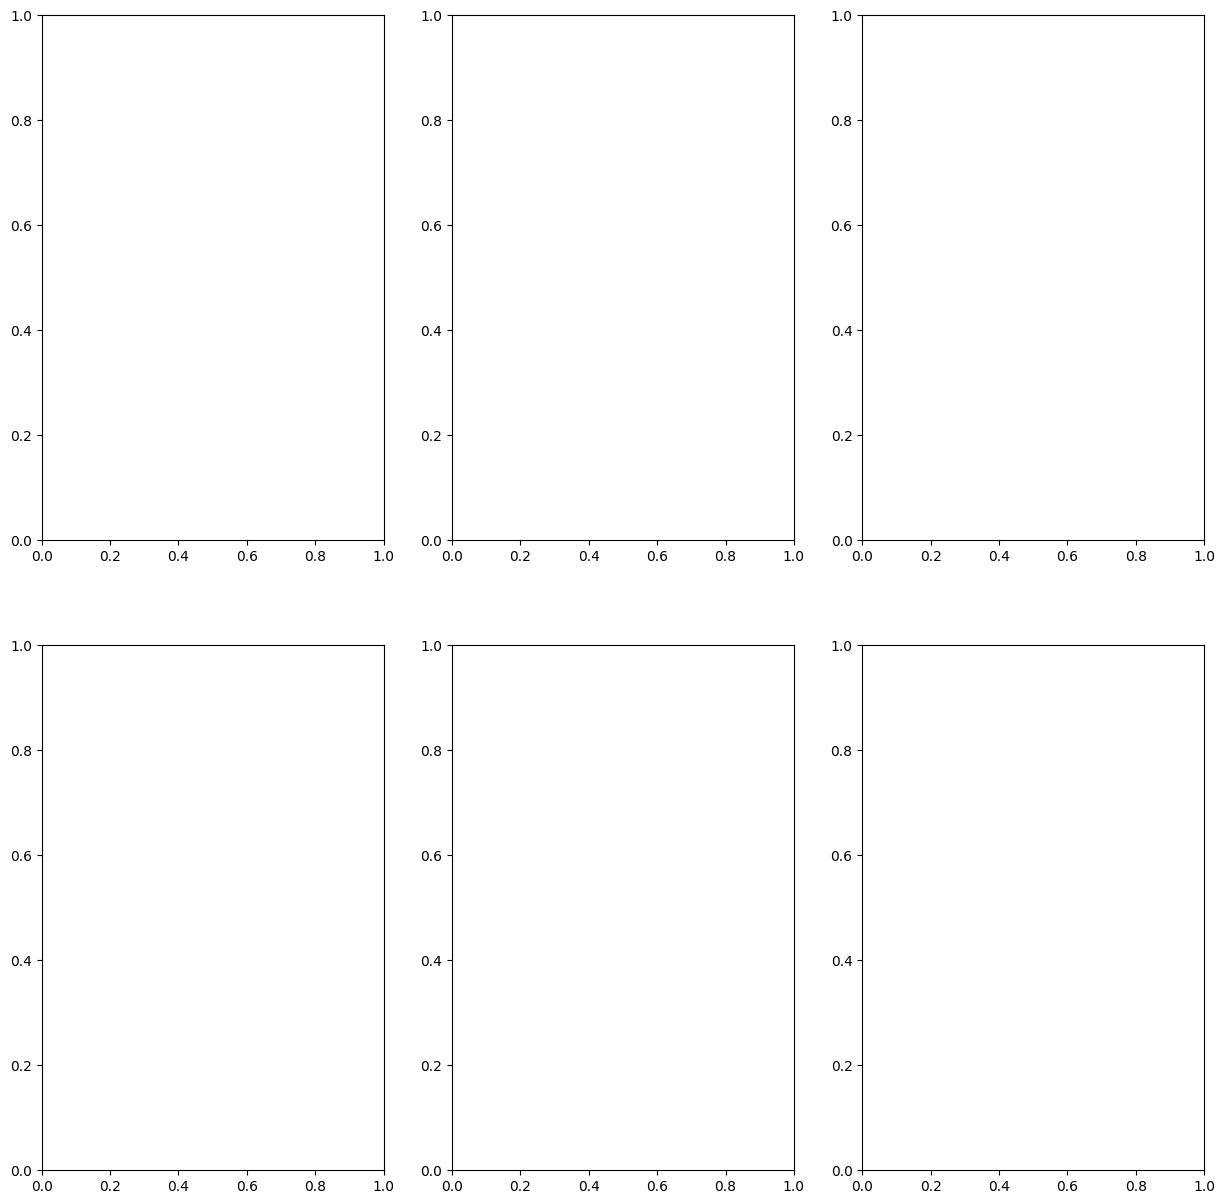

In [21]:
# Train model
epochs = 30
train_losses, test_losses     = [], []
train_recall, train_precision = [], []
test_recall, test_precision   = [], []

def mask_to_image(mask):
    # Permute ndarray to (H, W, C) with np.transpose
    mask = np.transpose(mask, (1, 2, 0))
    return mask

for epoch in range(epochs):
    fig, ax = plt.subplots(2, 3, figsize=(15, 15))

    # Train
    train_loss, train_rec, train_prec, input_image, output_image, target_mask = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_recall.append(train_rec)
    train_precision.append(train_prec)

    # Plot and print
    print(f'Epoch {epoch}, train loss: {train_losses[-1]:.4f}, train recall/precision: {train_recall[-1]:.4f}/{train_precision[-1]:.4f}')
    # print(f'input_image: {input_image[0].shape}, output_image: {output_image[0].shape}, target_mask: {target_mask[0].shape}')
    ax[0,0].imshow(mask_to_image(input_image[0]), aspect='equal')
    ax[0,1].imshow(mask_to_image(output_image[0]), aspect='equal')
    ax[0,2].imshow(mask_to_image(target_mask[0]*255).astype(np.uint8), aspect='equal')
    # create_plot(np.transpose(input_image, (0,2,3,1)), np.transpose(output_image, (0,2,3,1)), np.transpose(target_mask, (0,2,3,1)), n_plots=1, figsize=(15,15))


    # Test
    test_loss, test_rec, test_prec, input_image, output_image, target_mask = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_recall.append(test_rec)
    test_precision.append(test_prec)   

    # Plot and print
    print(f'Epoch {epoch}, test loss: {test_losses[-1]:.4f}, test recall/precision: {test_recall[-1]:.4f}/{test_precision[-1]:.4f}')
    ax[1,0].imshow(mask_to_image(input_image[0]), aspect='equal')
    ax[1,1].imshow(mask_to_image(output_image[0]), aspect='equal')
    ax[1,2].imshow(mask_to_image(target_mask[0]*255).astype(np.uint8), aspect='equal')
    plt.show()
    # create_plot(np.transpose(input_image, (0,2,3,1)), np.transpose(output_image, (0,2,3,1)), np.transpose(target_mask, (0,2,3,1)), n_plots=1, figsize=(15,15))


In [ ]:
import csv

# Plot losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.savefig("loss.pdf")

# train_acc = torch.tensor(train_accuracies).detach().cpu().numpy()
# test_acc = torch.tensor(test_accuracies).detach().cpu().numpy()
# Plot accuracies
# plt.plot(train_acc, label='Training accuracy')
# plt.plot(test_acc, label='Validation accuracy')
#plt.plot(test_accuracies, label='Validation accuracy')

train_recall = torch.tensor(train_recall).detach().cpu().numpy()
test_recall = torch.tensor(test_recall).detach().cpu().numpy()
train_precision = torch.tensor(train_precision).detach().cpu().numpy()
test_precision = torch.tensor(test_precision).detach().cpu().numpy()

plt.plot(train_recall, label='train_recall')
plt.plot(test_recall, label='test_recall')
plt.title('Training and validation recall')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()
plt.show()
plt.savefig("recall.pdf")


plt.plot(train_precision, label='train_precision')
plt.plot(test_precision, label='test_precision')
plt.title('Training and validation precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()
plt.show()
plt.savefig("precision.pdf")

with open('single_class_rgb.csv','w', newline='') as datafile:
    writer = csv.writer(datafile)
    writer.writerow(['epoch', 'loss_train', 'loss_test', 'recall_train', 'precision_train', 'recall_test', 'precision_test'])
    
    #code and stuff

    writer.writerow([epoch, train_losses[-1], test_losses[-1], train_recall[-1], train_precision[-1], test_recall[-1], test_precision[-1]])
